# Computing Player Roles/Types Using K-Means Clustering

Identifying groups of football players that are similar to each other is inherently difficult because there are so many moving pieces. Players are often classified by their position, but this doesn't really tell us a great deal about the player beyond where they line up in a team's formation. It doesn't tell us the role they play, or how they compare to other players. Full-backs can act as creators, strikers may be high-pressing defenders, and midfielders can perform virtually any role. Grouping similar players at a more granular level than position is also difficult because there is no established, systematic way of classifying player roles/types. The wealth of event data available for players across Europe, and the lack of an established method or existing classification labels for players, lends itself to unsupervised learning techniques like clustering.

However, clustering in high-dimensional spaces faces the dimensionality curse and the inability to know the ground truth. The particular challenges in this case are as follows:

- High dimensional spaces are hard to comprehend and to visualize (and therefore hard to study in practice)
  - The concept of distance (and therefore the basis for producing meaningful clusters) is less precise when dealing with higher number of dimensions
- The clusters and the features (variables) needed to produce accurate clusters are unlikely to vary linearly across positions
- There is likely to be some (or lots) of correlation between several of the features in the dataset

Therefore, the best approach is to first reduce the number of dimensions as much as possible, using dimensionality reduction and manifold learning, before fitting a clustering algorithm to identify midfield types.

In [1]:
import pickle

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer
from yellowbrick.target.feature_correlation import feature_correlation


In [2]:
# load dataset
df = pd.read_csv("big_five.csv")

## Midfielders

### Feature Selection

Feature selection helps us to overcome several of the principle issues with the clustering approach. In particular, it can reduce the number of dimensions so that only the most theoretically-sound features are included, and it can reduce the multicollinearity in the feature set. There will be a lot of features that are strongly correlated with each other, and in those cases, using fewer of these features is preferable.

For the moment, I have focused on theory-driven feature selection, informed by tests of correlation between features, but future steps should involve developing more empirically-grounded feature selection.

In order to carry out the selection, it is necessary to make certain assumptions about the type of similarities that this project hopes to identify:

1. Are we identifying similar players based on similarities in quality of performance or style of play?
   - I have focused on identifying similar types of players, rather than similar levels of performance, however there is room for extending this and adding a second clustering algorithm that groups players in the same classes by performance.
   - Focusing on quality first seems like a flawed approach, as style of play will bias results. Instead, identifying clusters of player roles/types is easier to do a little more independently of quality.
2. I have chosen to split players into position groups before identifying the subgroups that exist within those position groups.
   - This is based on the assumption that different positions (DF, MF, FW) generally require different sets of features to accurately cluster by role.
   - While there is merit to a broader approach, I think this would require a more complex strategy for feature selection, because the features that are most important for types of offensive players will be different to those that would be most influential for defensive players.
     - This would involve subspace clustering, which complicates the process a great deal, and I'm not convinced that it would ultimately improve the results significantly.

As a result of the above assumptions, I have selected features that are theoretically important in defining player roles/styles by position, and have tried to limit those features that seem to correspond to successful events, focusing more on attempts.

<!--
#TODO:
- Look at implementing Lasso & Weighted K-Means feature selection for clustering
  - Will this improve the feature selection process in a meaningful way?
  - Will these allow for the inclusion of larger set of features, and as a result, more detailed modeling?
  - Is there the potential for features that wouldn't be identified by theory-driven approach?

Lasso Process:

1. Assigns equal weights to every feature
2. Finds clusters according to weights of features
3. Computes objective of the method
4. Optimizes L1-penalty for found objective
5. Computes new feature weights using objective
6. If new weights equal to the old ones, then break, and otherwise repeat steps 2-6
7. Select top k features according to weights

Weighted K-Means Process:

1. Randomly assigns values for feature weights in a way that keeps their sum equal to 1
2. Find clusters using samples multiplied by weights in the power of beta
3. Compute score for clustering
4. Recompute weights (see http://www.public.asu.edu/%7Ehuanliu/papers/pakdd00clu.pdf)
5. Find clustering using new weights: if score of new clustering didn’t change, stop algorithm, otherwise return to step 2.
6. Select top k features according to their weights

-->

In [3]:
# subset df to select features for clustering midfielders
X = (
    # select midfielders that have played more than 900 mins
    df.loc[(df["position"] == "MF") & (df["mins"] > 900)].dropna()
    # select features
    [
        [
            "shots",
            "sca",
            "ppa",
            "crosses",
            "through_balls",
            "prog_pass",
            "prog_carries",
            "dribble_att",
            "aerial_duels",
            "tkl_int",
            "pressures",
            "touches_def_pen",
            "touches_def_third",
            "touches_mid_third",
            "touches_att_third",
            "touches_att_pen",
        ]
    ]
)

### Dimensionality Reduction

Dimensionality refers to the the coordinates required to plot a point in a space. The number of dimensions in a dataset corresponds to the number of features/variables. High-dimensional data is harder to visualize, and harder to understand, making analysis more difficult.

This is especially true with clustering tasks. The curse of dimensionality is one of the primary issues facing any clustering of data with a large number of features. While the number of features in these cases are not astronomical, it's still difficult to think about in a meaningful way, and it is therefore difficult to assess results.

#### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a linear projection-based method for dimensionality reduction. It transforms multidimensional data by projecting onto orthogonal axes. Effectively, it reduces the number of dimensions of a data set by identifying the underlying or latent factors driving variance, and transforming the data in a way that represents that variance in fewer dimensions.

For a more in-depth discussion and visual representation of PCA and dimensionality reduction:

- Explained Visually - [Principal Component Analysis](https://setosa.io/ev/principal-component-analysis/)

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a type of manifold learning, a non-linear method of dimensionality reduction. t-SNE helps produce more accurate clusters by converting data into a two-dimensional space, and it is particularly valuable for k-means clustering, because the shape of the sample is close to circular, which works well with k-means.

t-SNE minmizes the divergence between two distributions: the distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarites of the corresponding low-dimensional points in the embedding.

For more details on t-SNE:

- [t-SNE Website](https://lvdmaaten.github.io/tsne/)
- [Visualizing Data Using t-SNE (The Original Paper)](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
- [Google Brain's How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)

In [4]:
def explained_var(df):
    """
    Estimating the number of features PCA should retain
    """
    # scaling data to reduce error
    df_std = StandardScaler().fit_transform(df)
    # principal component analysis
    pca = PCA(random_state=10)
    pca.fit_transform(df_std)
    # cumulative variance explained by features
    total_explained_variance = pca.explained_variance_ratio_.cumsum()
    # store n_comps globally for use in pipeline
    global n_comps
    # identify number of features for explained variance > 0.95
    n_comps = len(total_explained_variance[total_explained_variance >= 0.95])
    # determine number of features
    n_comps = df.shape[1] - n_comps + 1

    print(("Features: {}").format(n_comps))
    print("Total Explained Variance: {}".format(total_explained_variance[n_comps-1]))

In [5]:
explained_var(X)

Features: 11
Total Explained Variance: 0.9533962839410821


In [6]:
# function for transforming data and reducing dimensions
def dim_reduction(df, p, l):
    """
    Tranforming data and reducing dimensions using PCA & t-SNE

    Args:
        df ([DataFrame]): df
        p ([int]): perplexity
        l ([int]): learning_rate
    """
    # scaling data to reduce error
    std = StandardScaler()
    X_std = std.fit_transform(df)
    # principal component analysis
    pca =  PCA(n_components=n_comps, random_state=10)
    X_pca = pca.fit_transform(X_std)
    # t-distributed stochastic neighbors embedding
    tsne =  TSNE(n_components=2,
                      verbose=1,
                      perplexity=p,
                      n_iter=8000,
                      random_state=10,
                      n_iter_without_progress=500,
                      learning_rate=l)
    global X_tsne
    X_tsne = tsne.fit_transform(X_pca)

In [7]:
dim_reduction(X, 30, 350)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1488 samples in 0.008s...
[t-SNE] Computed neighbors for 1488 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1488
[t-SNE] Computed conditional probabilities for sample 1488 / 1488
[t-SNE] Mean sigma: 0.990020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.350502
[t-SNE] KL divergence after 6400 iterations: 1.491385


### Estimating _K_ Clusters

Estimating the optimal _K_ parameter, which is the number of clusters that the data will be split into, is difficult when dealing with unlabeled data. By nature, the ground-truth about the data is unknown. While some algorithms don't require _K_ to be determined b they often do, and those that don't require other parameters that are just as difficult (if not more difficult) to estimate. The algorithm used in this analysis is k-means, and the k standa

Two common approaches to estimating _K_ (and the two methods used below) are the elbow method and silhouette coefficients.

#### The Elbow Method

The elbow method plots the effect that varying the value of _K_ has when computing k-means, typically plotting the sum of squared errors for each value of _K_. If there is a clear kink, or "elbow", in the line that plots _K_, that means that that value is the correct number of clusters.

#### Silhouette Coefficients

Silhouette coefficients compute the density of clusters from the model's results. The coefficient is calculated for each cluster, and it evaluates how well defined a model's clusters are.

A silhoutte coefficient for a single sample is the difference between the mean intra-cluster distance (the mean distance between the observation and all other observations in the cluster) and the mean nearest-cluster distance (mean distance between the observation and all other observations of the nearest cluster), and normalized by the maximum value, producing a score between 1 (very dense) and -1 (very sparse). The coefficient for a set of samples is the mean of the coefficient for each sample.

The silhouette coefficient is plotted below using the elbow method, to determine the highest score across a range of values of _K_, and a silhouette plot, which plots the score and density for each cluster.

In [8]:
# set figure parameters
# set fonts
matplotlib.rcParams["font.sans-serif"] = "IBM Plex Sans"
matplotlib.rcParams["font.family"] = "sans-serif"

# set figure size
plt.rcParams["figure.figsize"] = [12, 6.75]
plt.rcParams["figure.dpi"] = 320

# set plot styles
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})

# define color palette
custom_palette = ["#457b9d", "#e63946", "#B34B7D", "#4D8C60"]

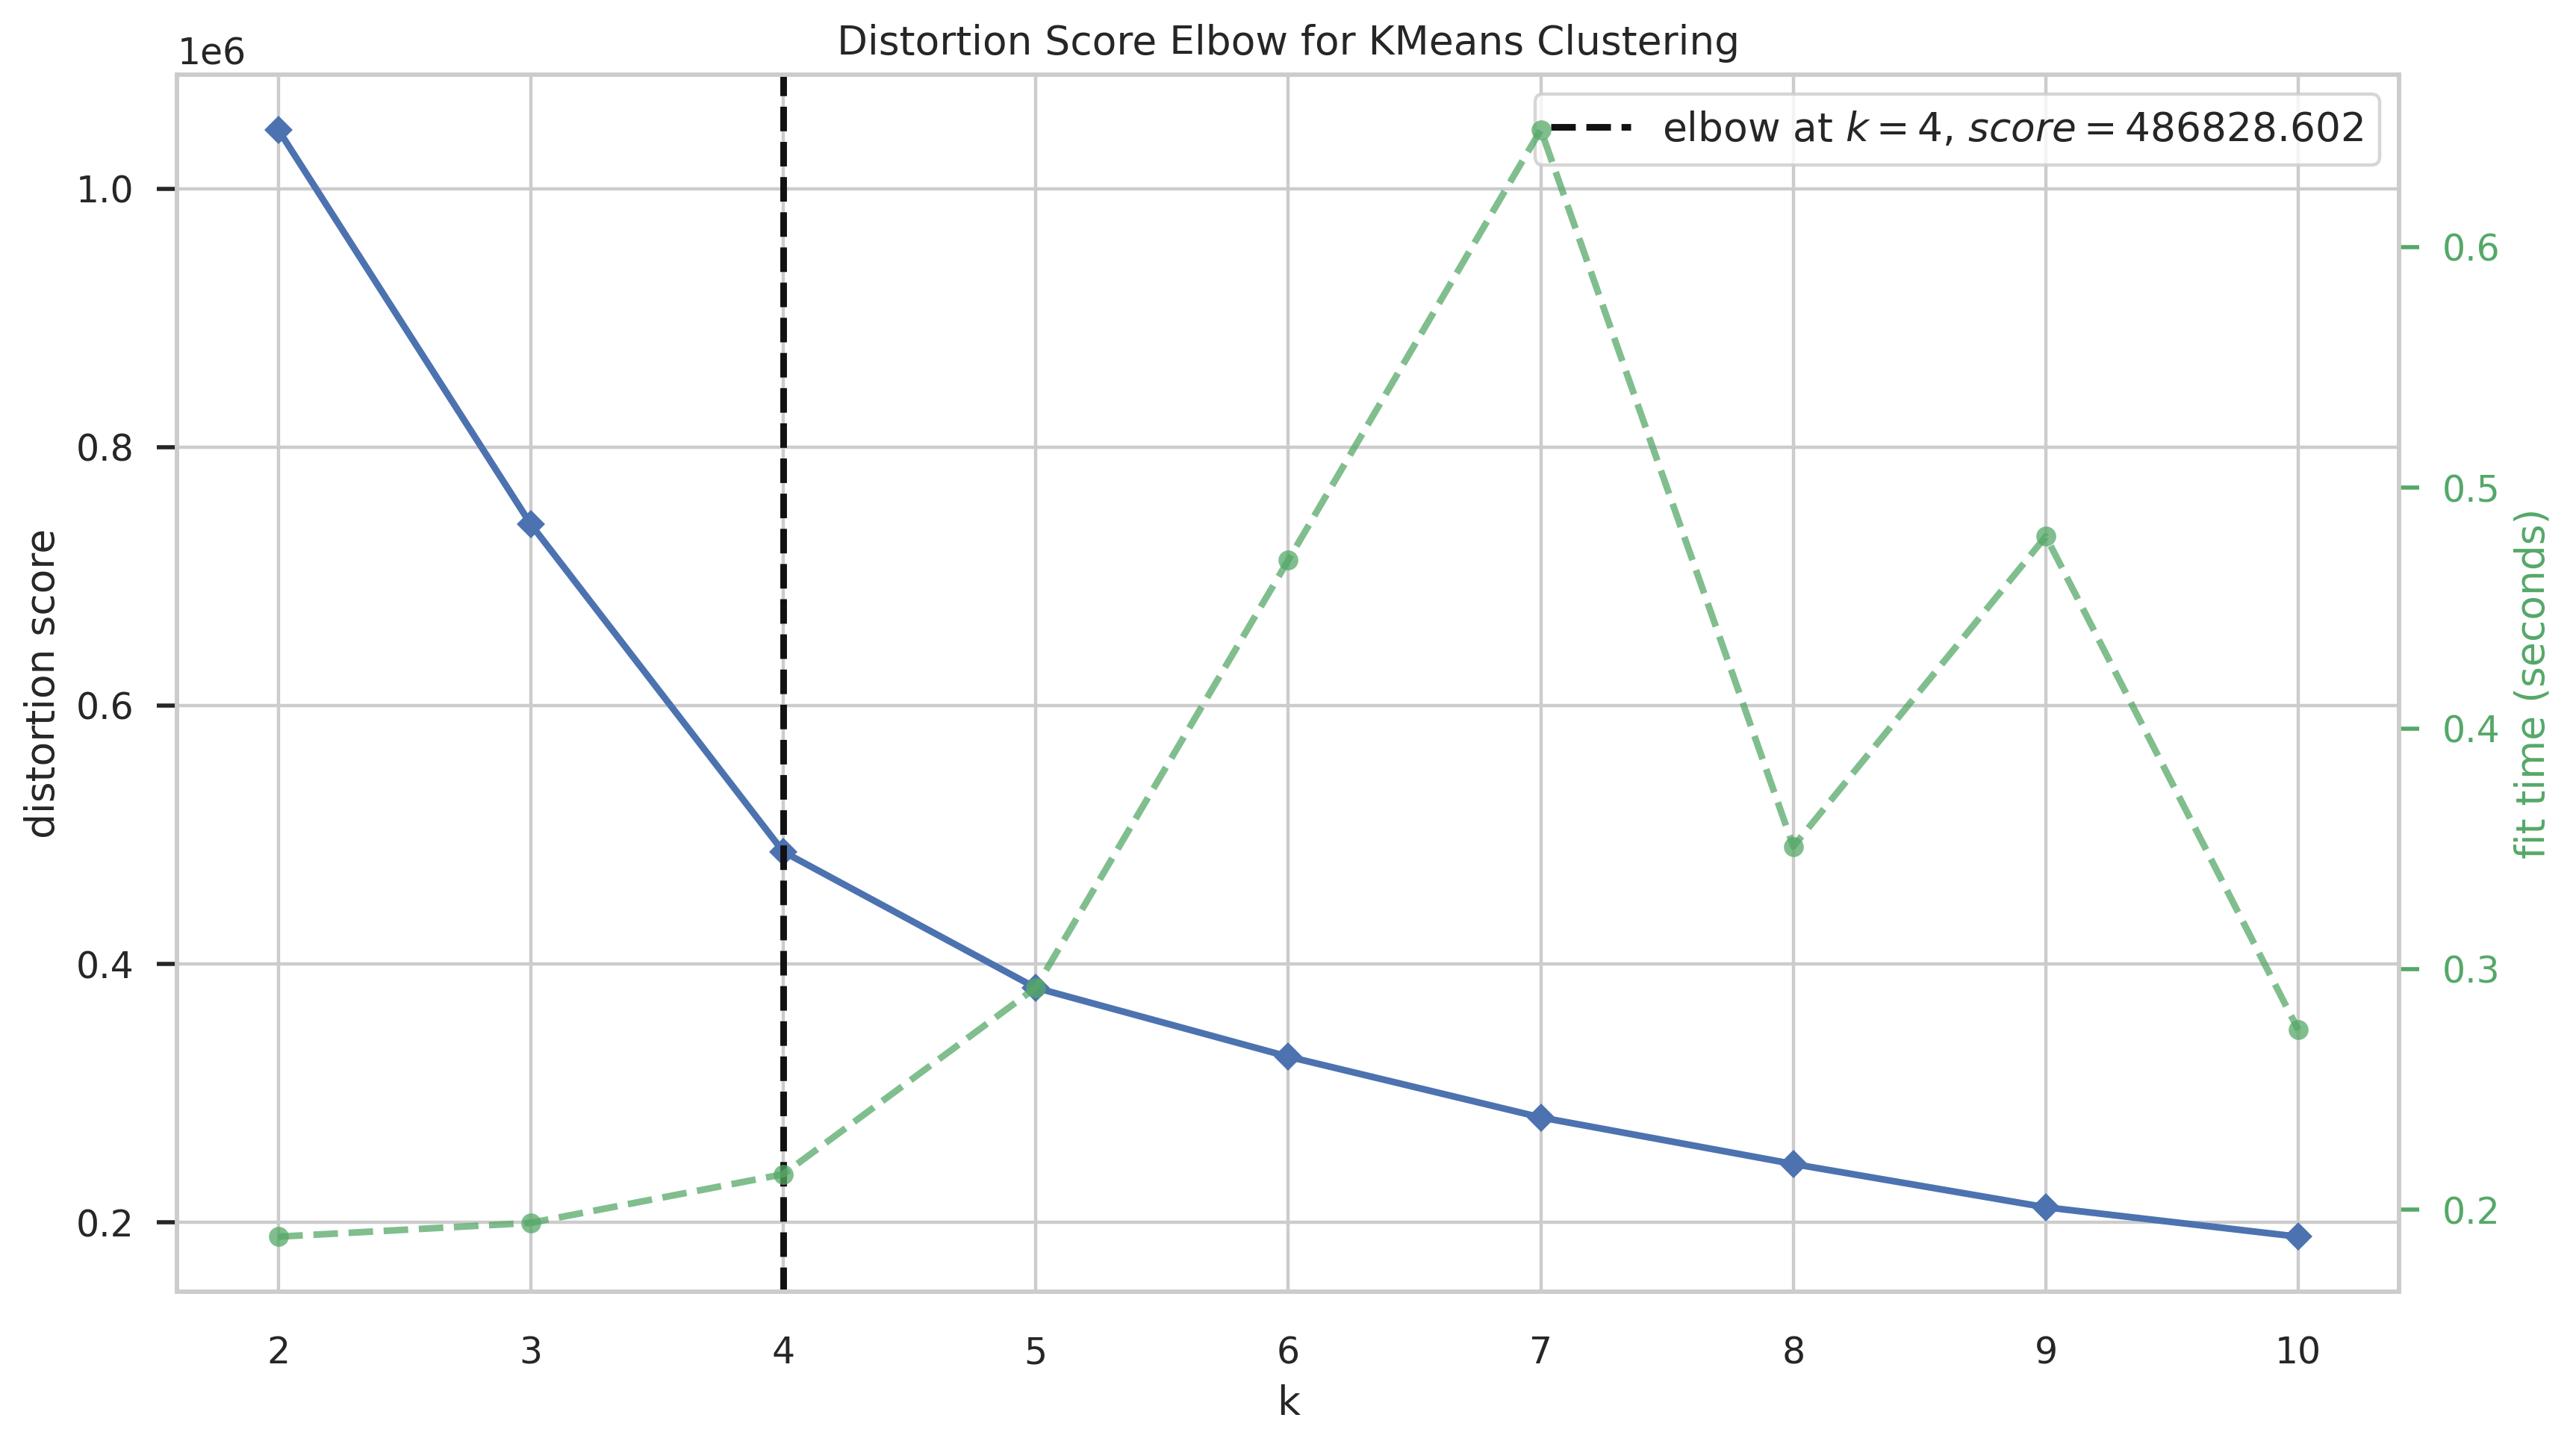

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [9]:
# distortion score identifying the elbow for the optimal k value
kelbow_visualizer(KMeans(random_state=10), X_tsne, k=(2, 11))

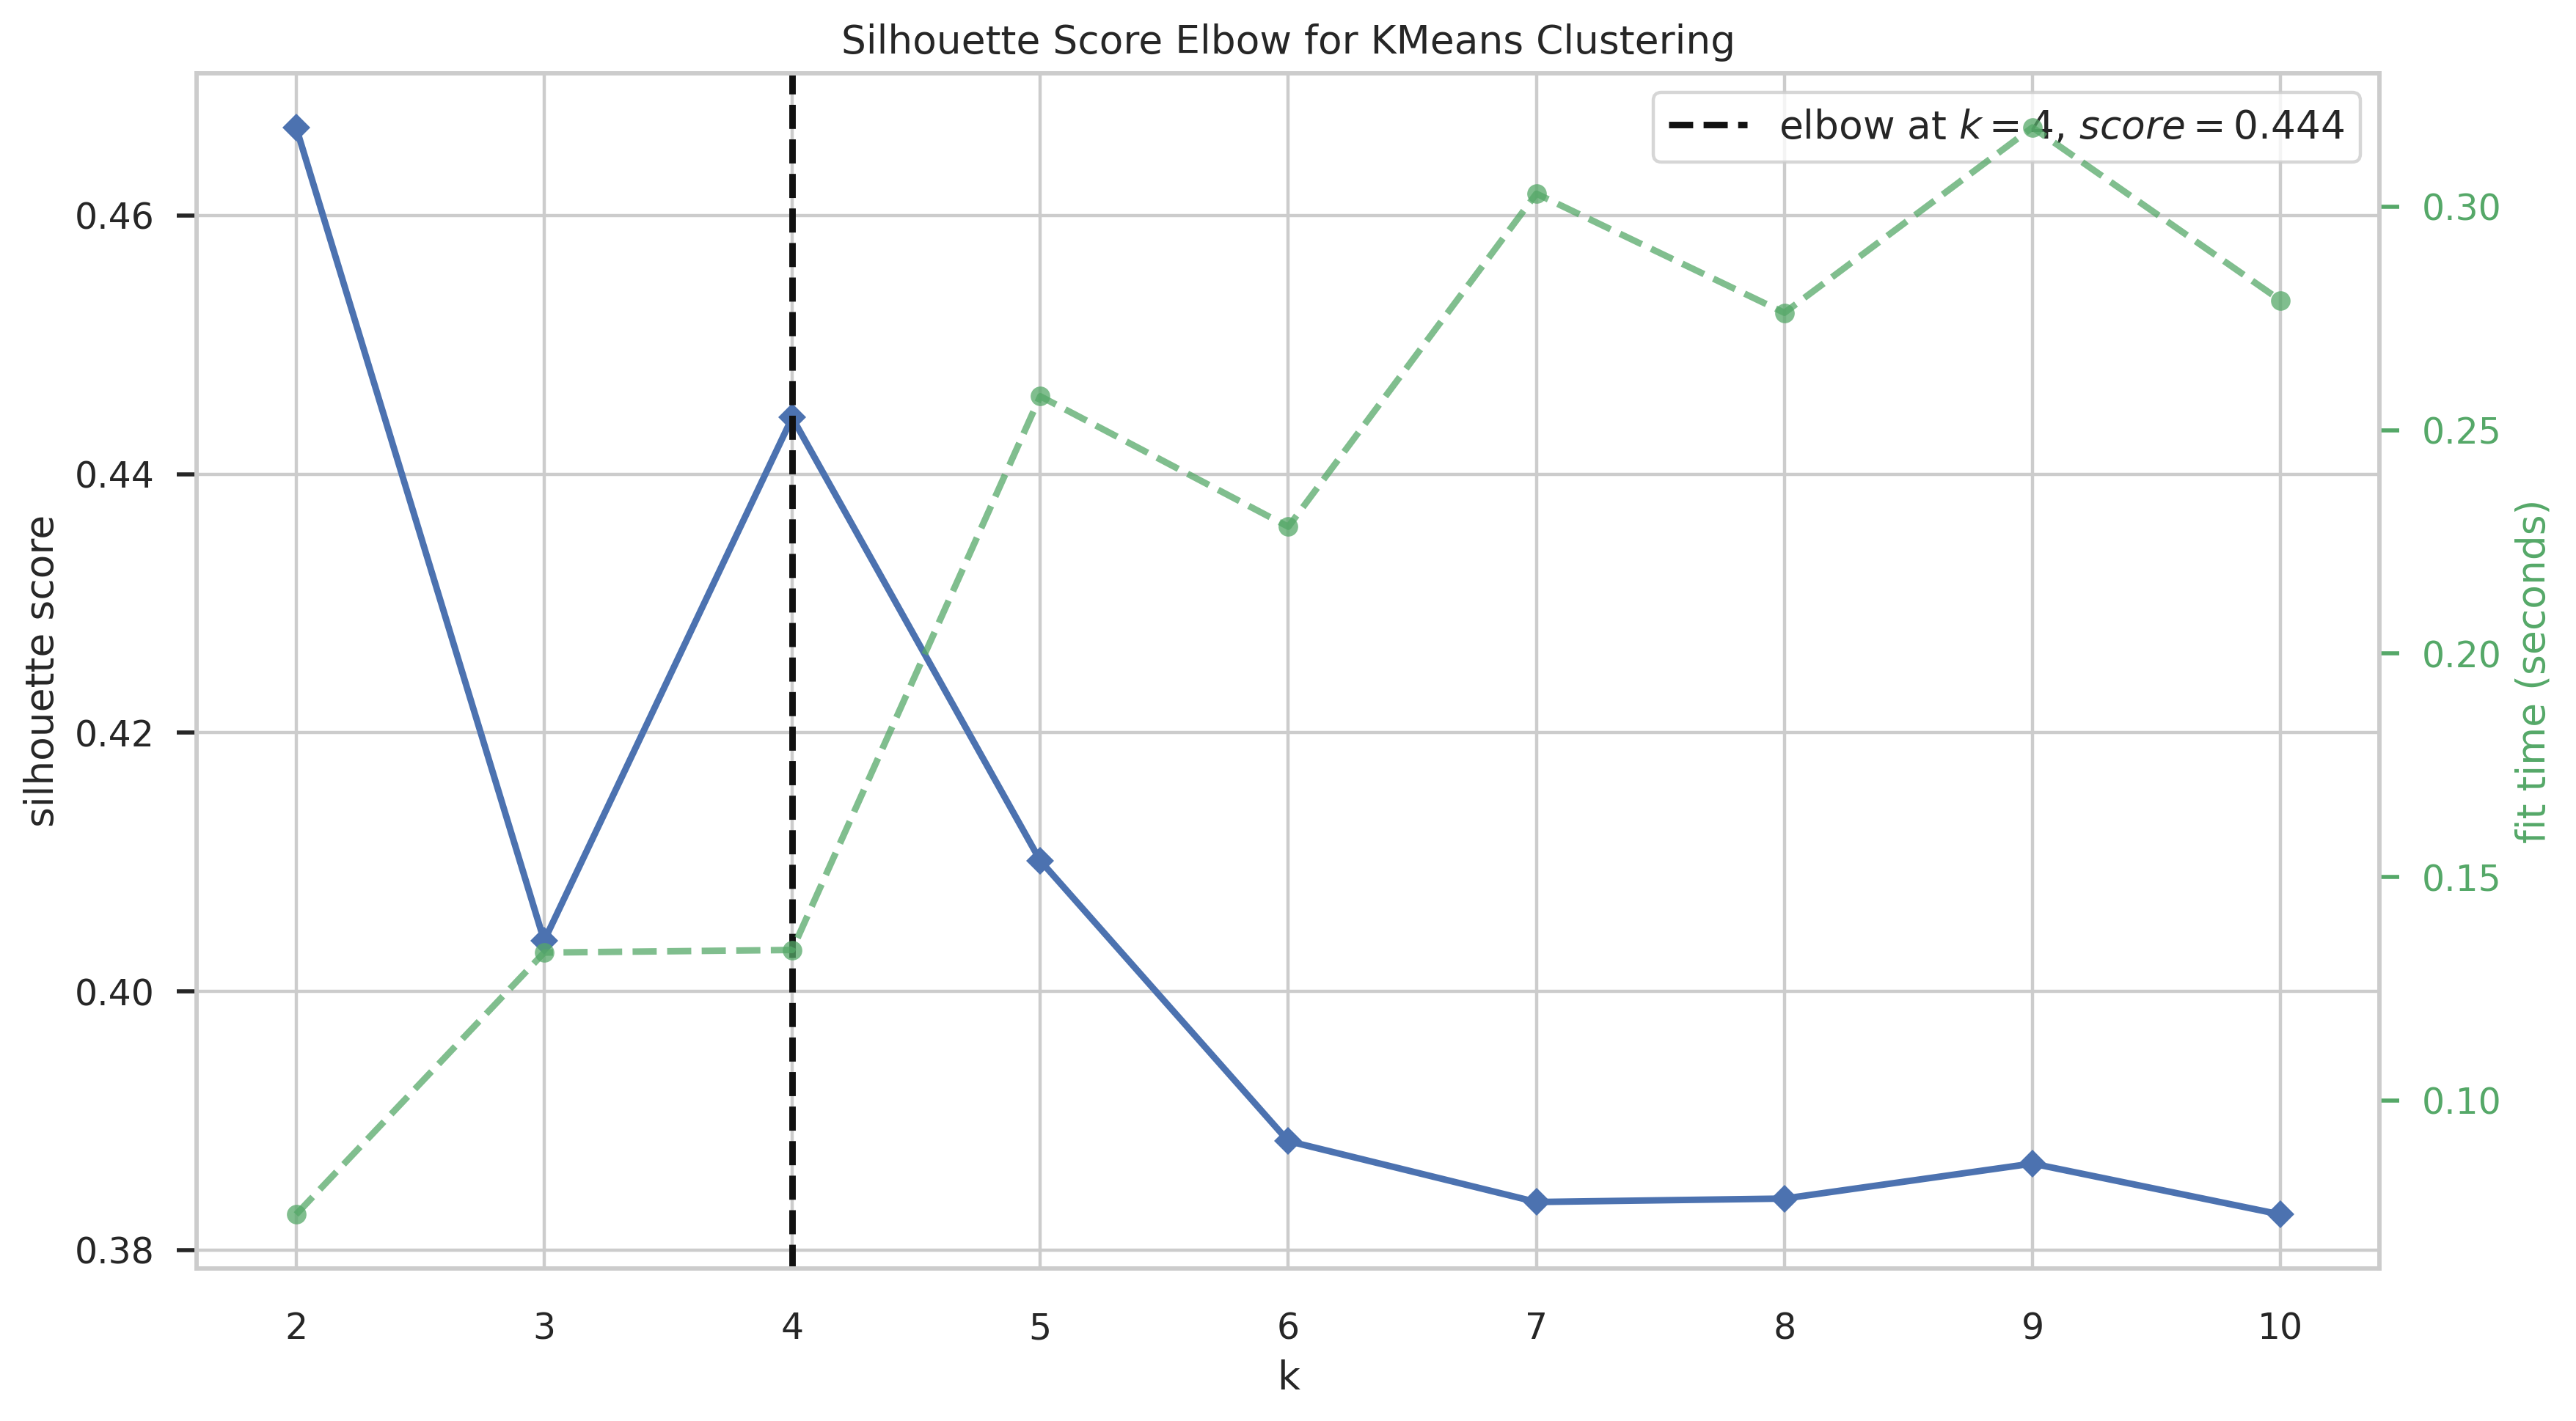

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=True)

In [10]:
# silhouette scores plotting the optimal k value
kelbow_visualizer(KMeans(random_state=10), X_tsne, k=(2, 11), metric="silhouette")

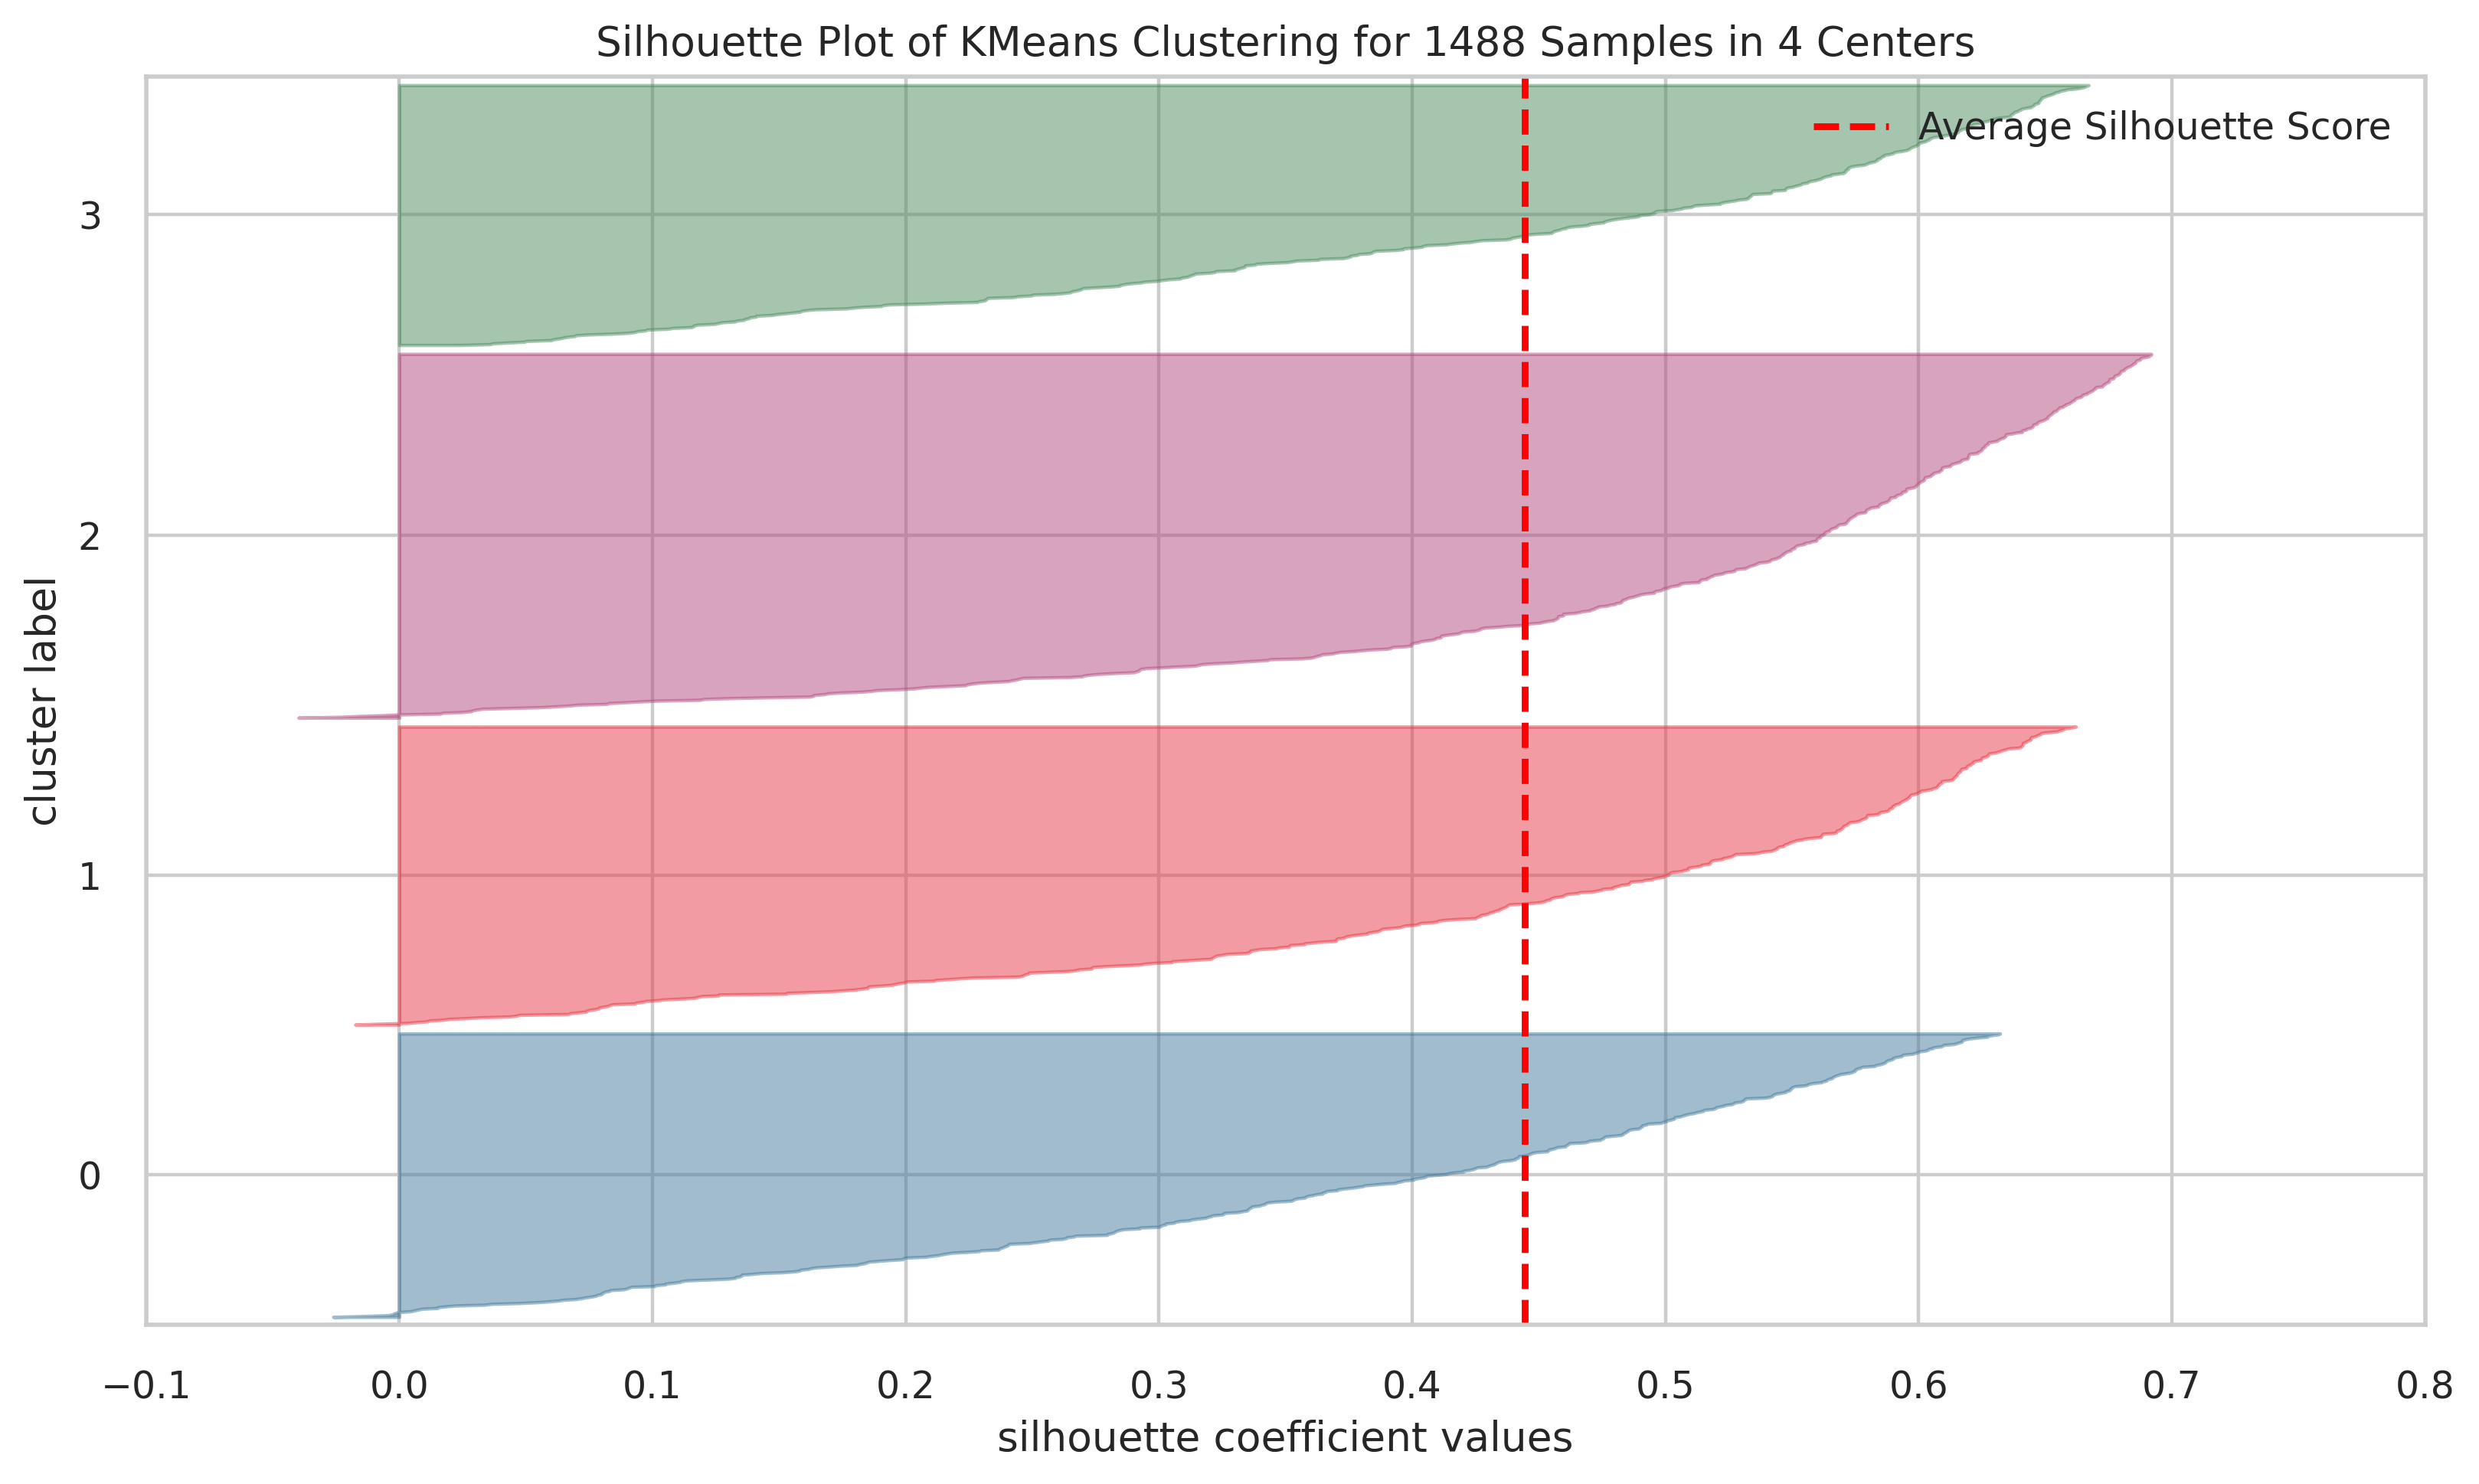

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1488 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors=['#457b9d', '#e63946', '#B34B7D', '#4D8C60'],
                     is_fitted='auto', model=None)

In [11]:
# silhouette plot when k=4
# the silhouette plots the score for observations in each cluster
# density is the thickness of each silhouette
silhouette_visualizer(
    KMeans(n_clusters=4, random_state=10), X_tsne, colors=custom_palette
)


### Cluster Analysis

The K-Means algorithm is the most popular clustering algorithm because it is reasonably intuitive, it scales well, and it is computationally simple.

K-Means clusters data by splitting samples into _n_ groups of equal variance, minimizing within-cluster sum-of-squares. It divides a set of _N_ samples _X_ into _K_ disjoint clusters _C_. It does this by randomly assigning values for the cluster centers (the mean value of the cluster centroid), assigning observations to their closest center, and then moving the centroid to the center of its sample, and then repeating the observation assignment and recalculation of the centroid until no observations change cluster.

For more details on the K-Means algorithm:

- [Understanding K-Means Clustering](https://datamahadev.com/understanding-k-means-clustering/)

In [12]:
# k-means using four clusters
km = KMeans(n_clusters=4, random_state=10)
# fit k-means algorithm on the data and save cluster labels
km.fit(X_tsne)
y = km.labels_

In [13]:
# create a df to store player names & season, cluster label, and distance from each cluster
players = pd.DataFrame(
    df.loc[(df["position"] == "MF") & (df["mins"] > 900)].dropna()[["player", "season"]]
)
labels = pd.DataFrame(y, columns=["cluster_label"], index=X.index)
cluster_locs = pd.DataFrame(km.fit_transform(X_tsne), index=X.index)
mf = pd.concat([players, labels, cluster_locs], axis=1, join="inner")

In [14]:
# expand pandas display to view all rows using pd.set_option()
# pd.set_option("display.max_rows", df.shape[0] + 1)

# sort df (by cluster label or player) for spot-checking results

# mf.sort_values("cluster_label")

In [15]:
# count the number of different clusters each player is assigned to
counts = pd.DataFrame(mf.groupby("player")["cluster_label"].nunique())
# identify the players that are only assigned to one cluster and drop them from the counts df
indexNames = counts[(counts["cluster_label"] == 1)].index
counts.drop(indexNames, inplace=True)
# count how many players are assigned to multiple clusters
len(counts)

# print counts to look at the players that are not labelled consistently
# print(counts)

174

#### Main Takeaways

Initial spot-checks suggest that the clusters are relatively consistent, with close to 700 players labeled in just one cluster. However, somewhere between 150-170 players are placed in more than one cluster.

While this may be the result of model error, there are other explanations that might not be erroneous:

- A player might play a different role from season to season, or develop as a player, leading them to fall into a different category.
- The team's playing style may have changed, and that may drive variance in certain players' statistics as a result.
- A player might have joined a new team and role/playing style might have changed in the process.

This needs further exploration, and if the results seem to be in error, then the model needs fine-tuning.

## Visualizing Clusters

In [16]:
# create a df with observation'ss x, y locations in two-dimensional space
scaled_df = pd.DataFrame(X_tsne, columns=["tsne1", "tsne2"])
# add cluster labels to the df
scaled_df = pd.concat([scaled_df, pd.DataFrame({"clusters": y})], axis=1)

<AxesSubplot:title={'center':'Midfield Clusters on tSNE Scaled Data'}, xlabel='tsne1', ylabel='tsne2'>

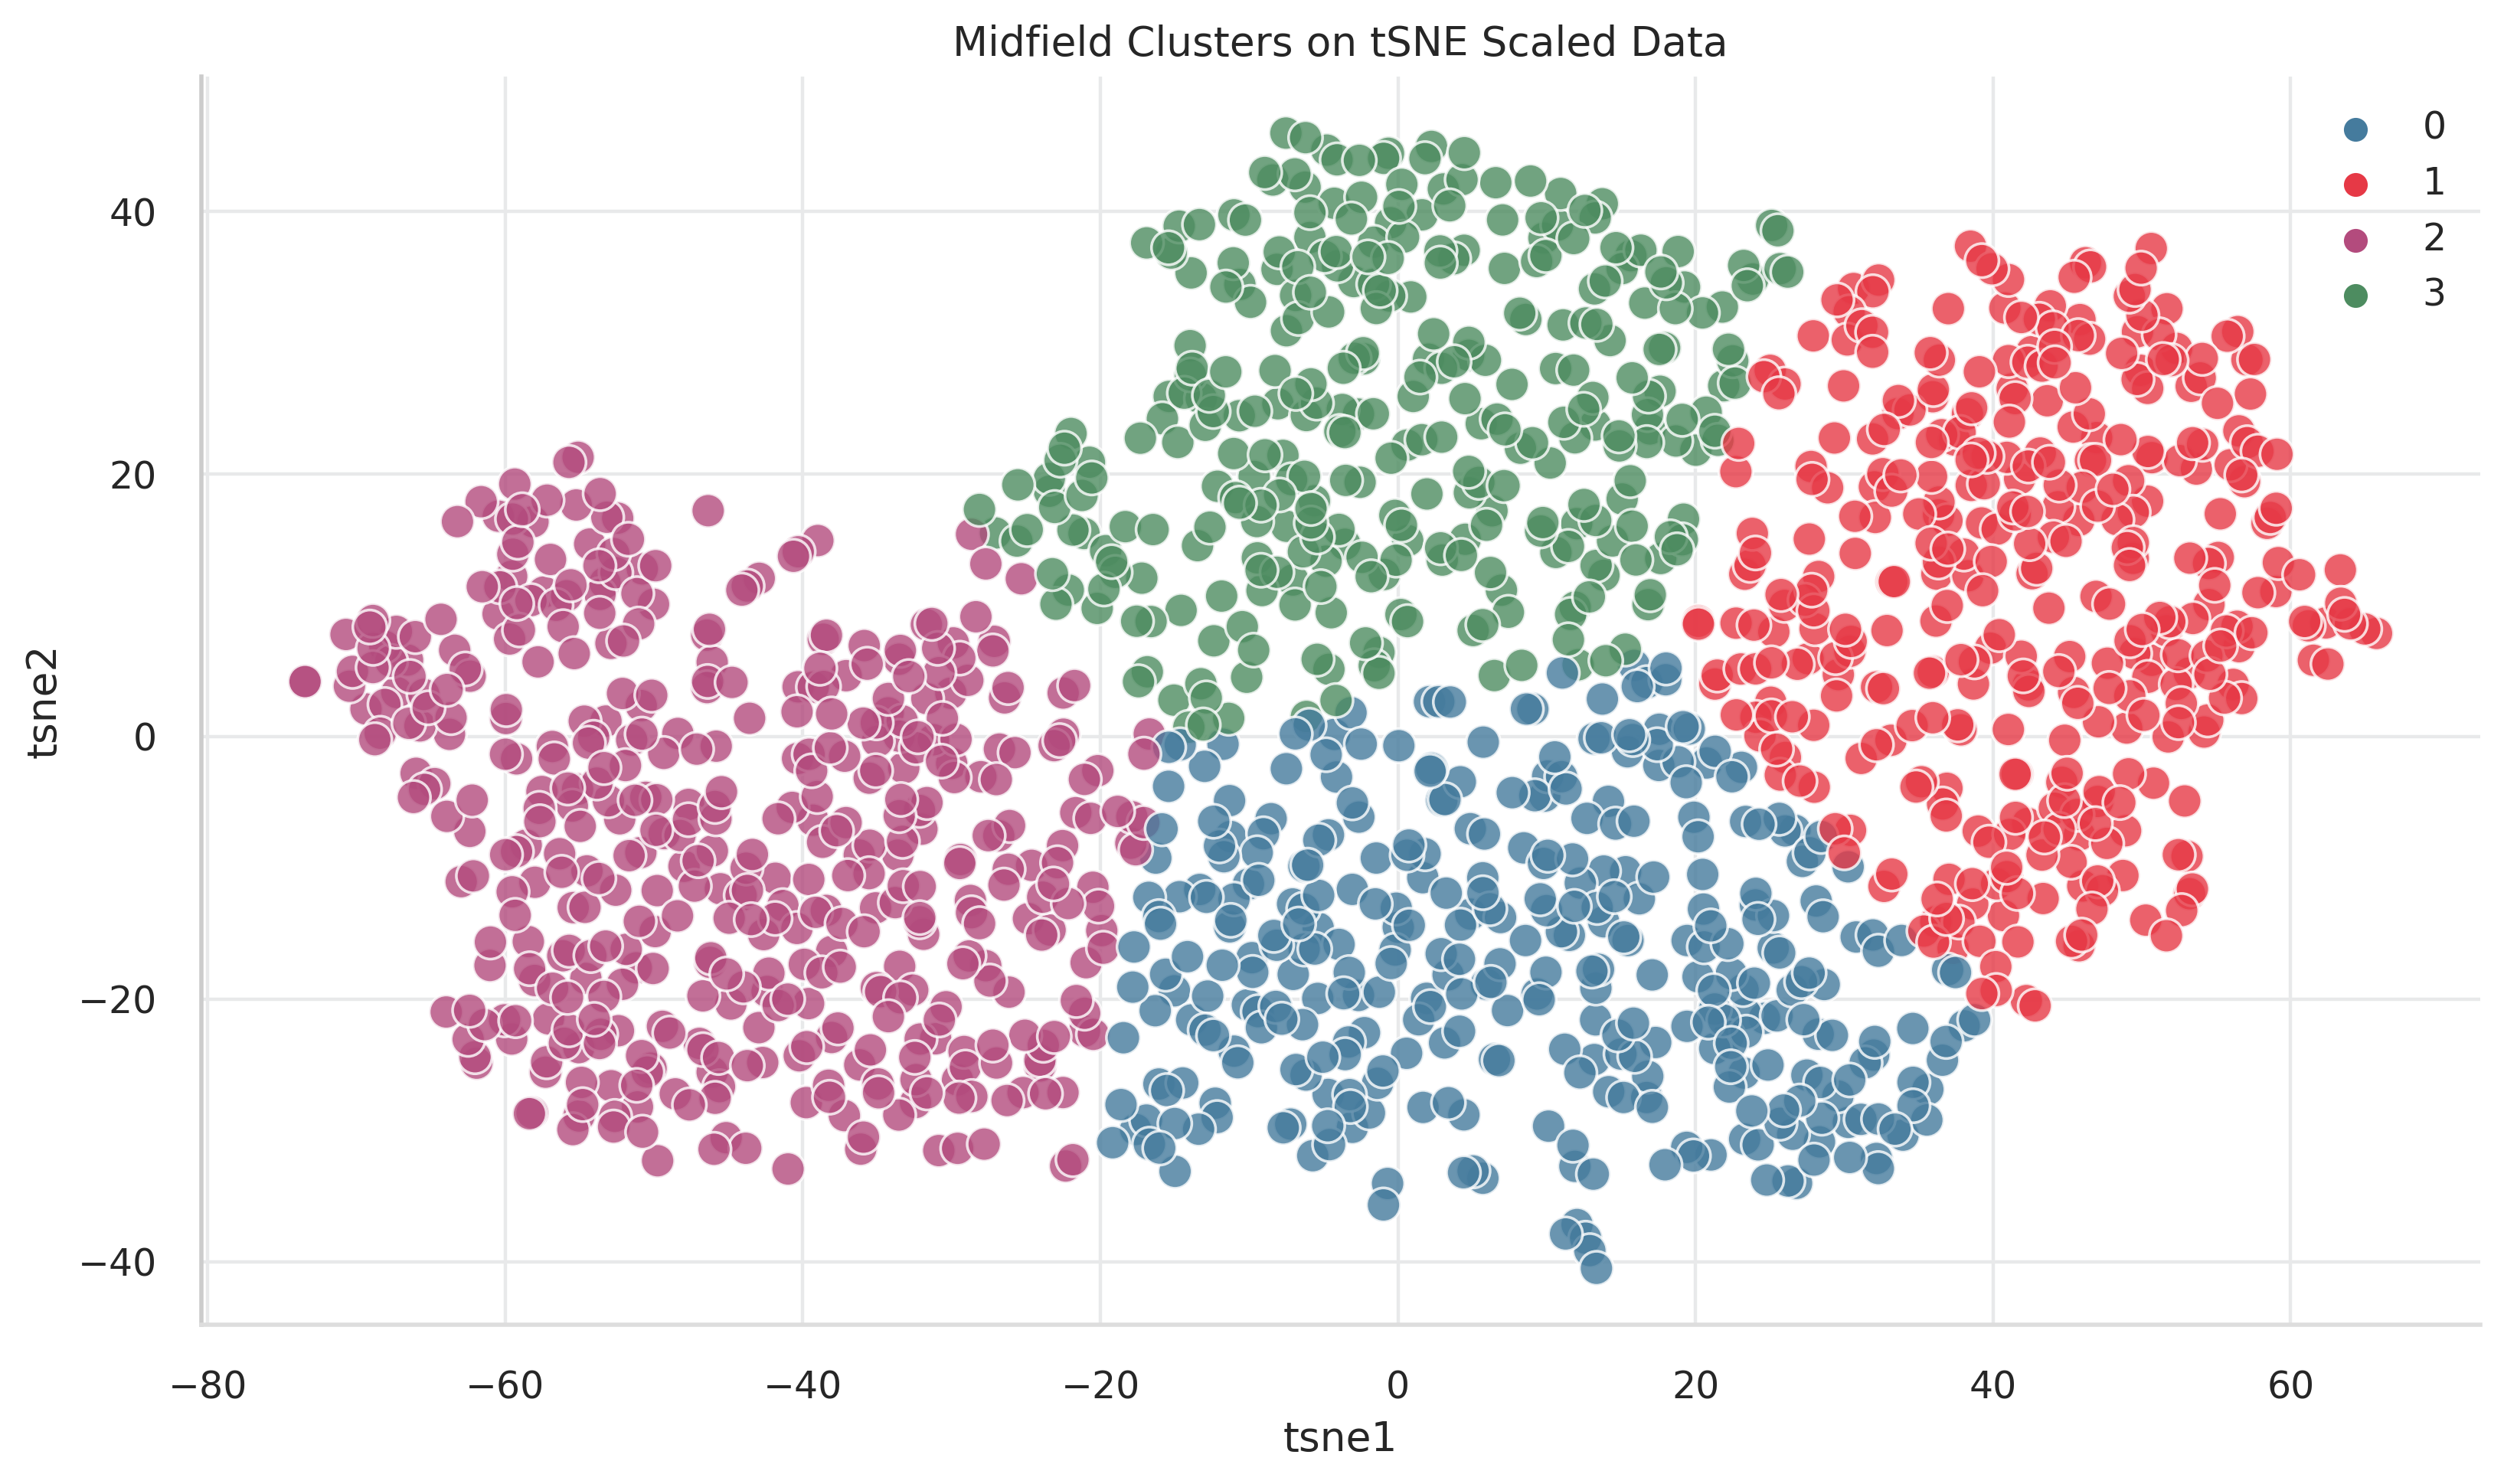

In [17]:
# plot tsne-scaled observations colored by cluster membership

def cluster_plot(df, pos):
    """
    Plot t-SNE-scaled observations colored by cluster membership
    """
    # create a new figure
    fig, ax = plt.subplots(figsize=(12, 6.75), dpi=320)
    # set plot title and style
    plt.title("{} Clusters on tSNE Scaled Data".format(pos))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible("#DDDDDD")
    ax.spines["bottom"].set_color("#DDDDDD")
    ax.yaxis.grid(True, color="#E8E9EA")
    ax.xaxis.grid(True, color="#E8E9EA")

    return sns.scatterplot(
        df.iloc[:, 0],
        df.iloc[:, 1],
        hue=y,
        palette=custom_palette,
        s=100, alpha=0.8)

cluster_plot(scaled_df, "Midfield")

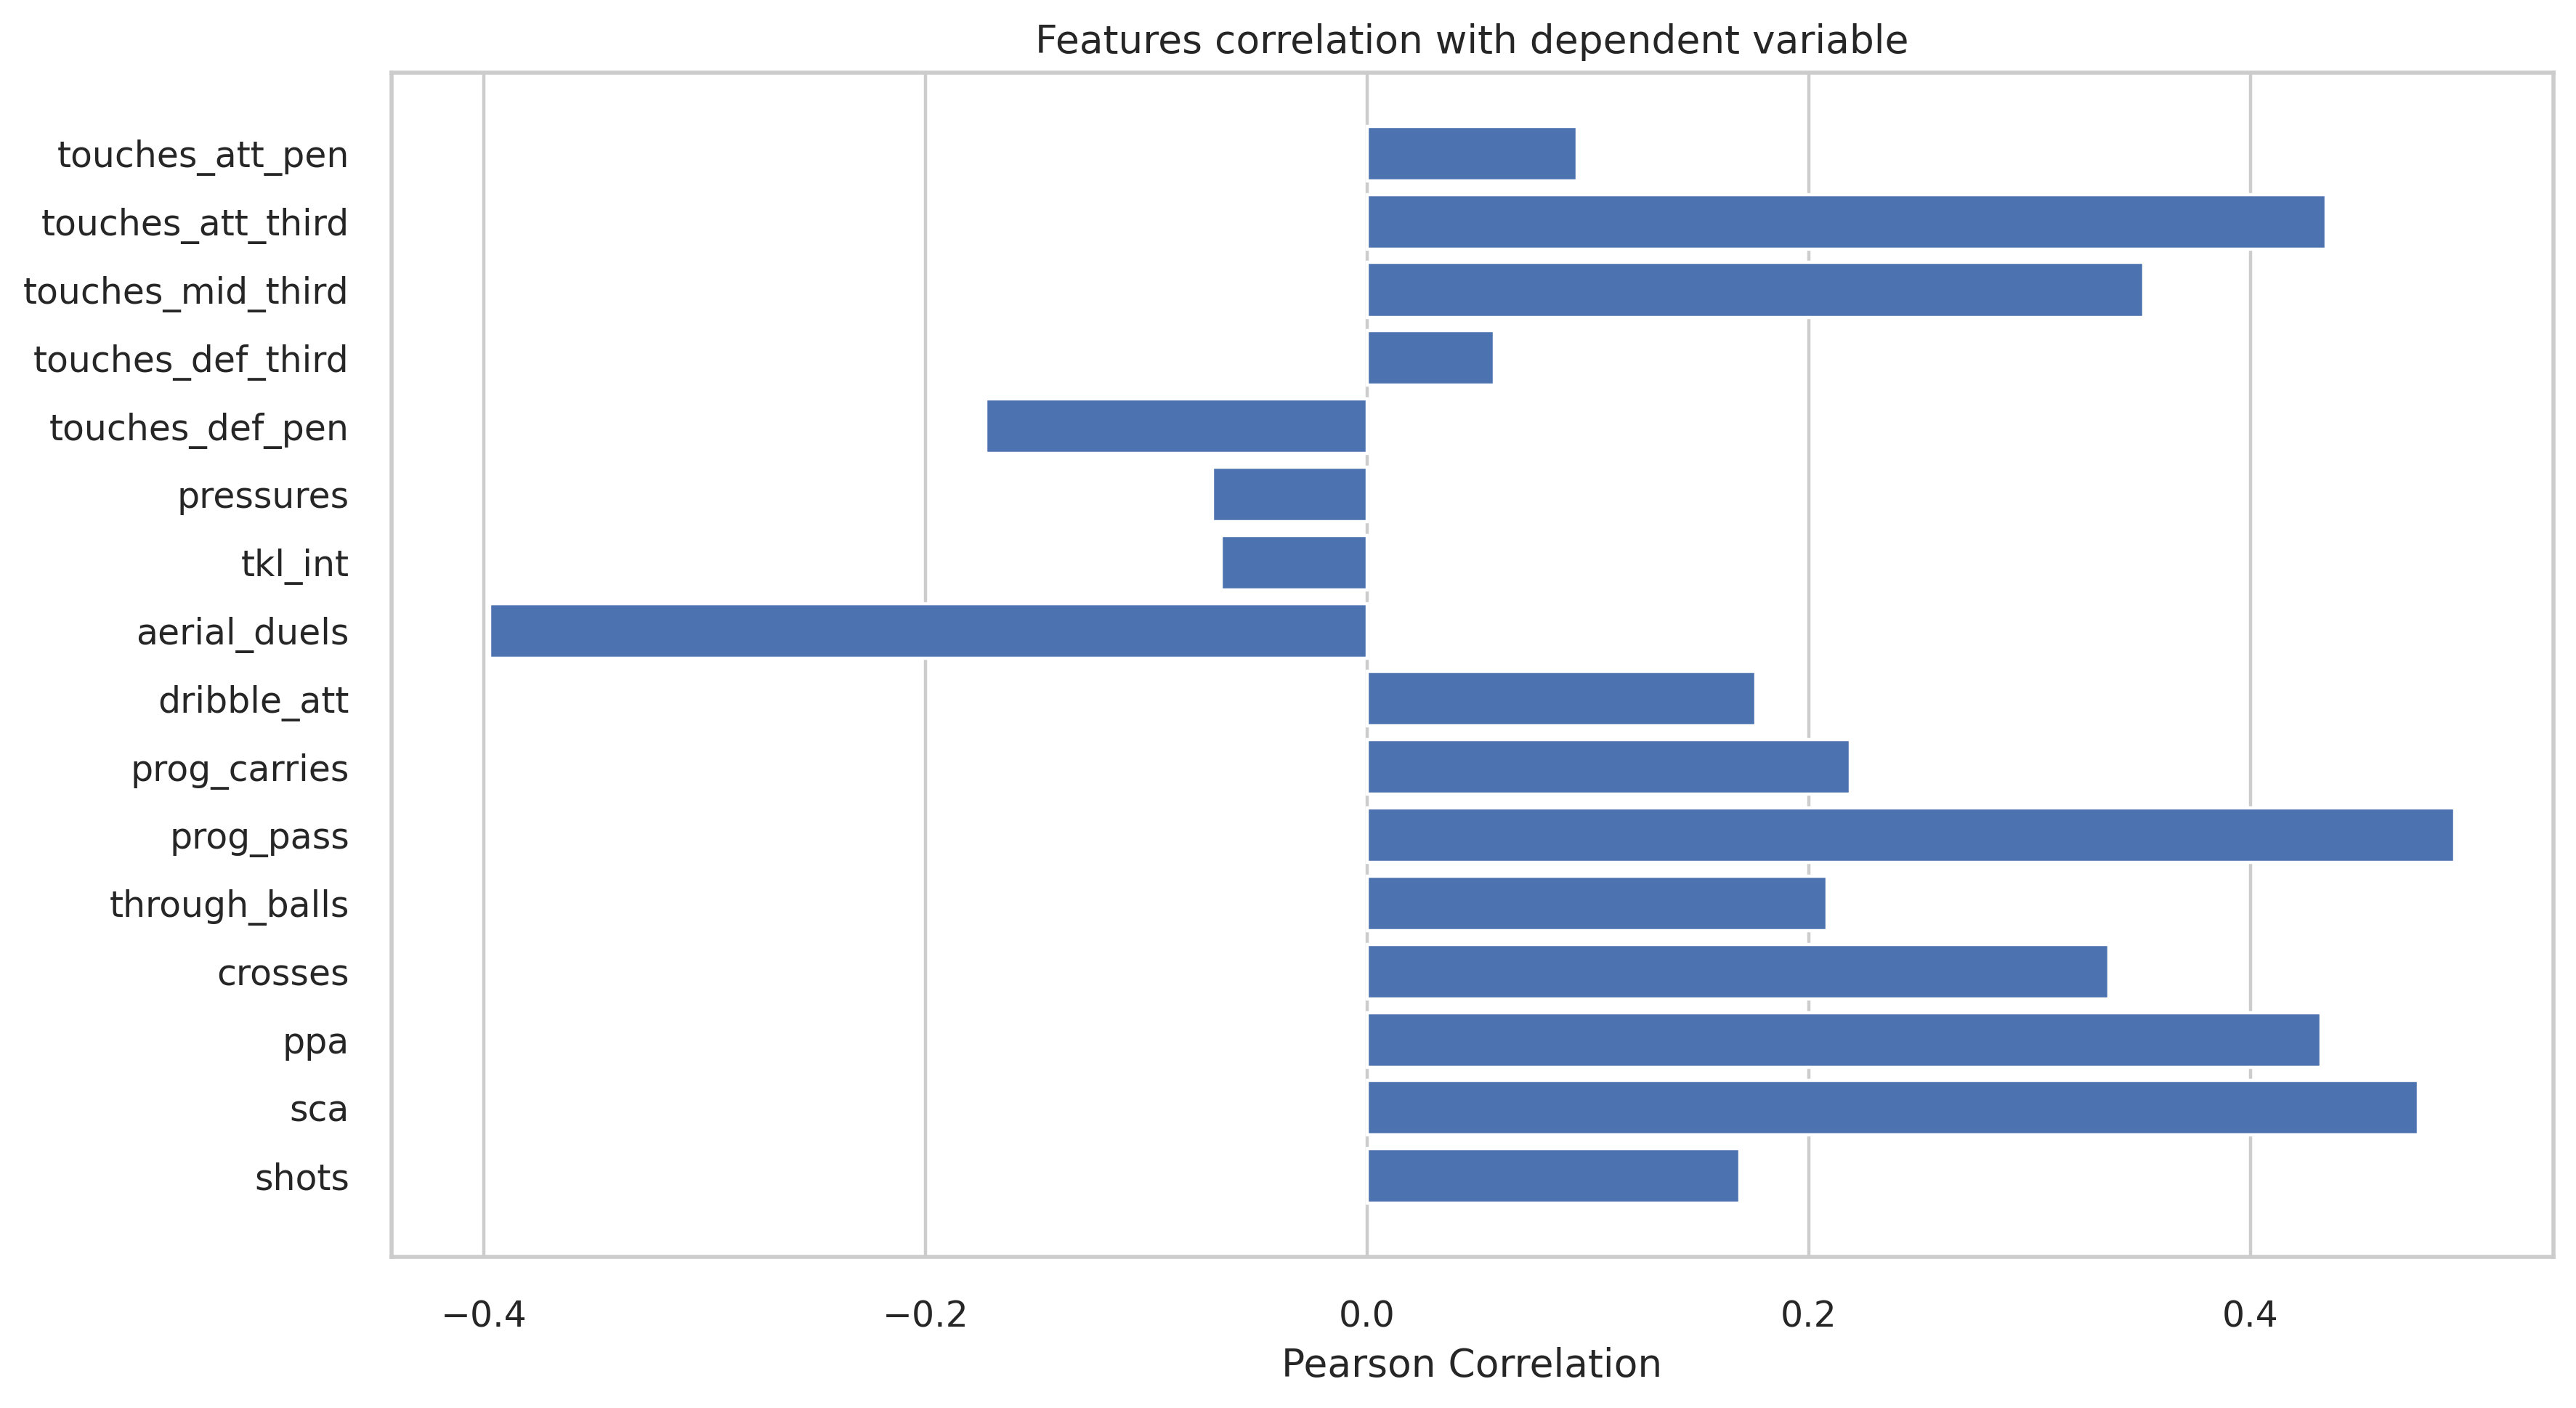

FeatureCorrelation(ax=<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>,
                   color=None, feature_index=None, feature_names=None,
                   labels=None, method='pearson', sort=False)

In [18]:
# plot the correlations between cluster labels and original features to see which features are driving most of the variance
# positive correlations driving higher cluster labels, negative correlations associated with lower values
feature_correlation(X, y)

### Pickling Model Outputs

In [19]:
pickle.dump(km, open("km_mids.pickle", "wb"))
pickle.dump(mf, open("mf_results.pickle", "wb"))

## Forwards

### Feature Selection

In [20]:
# subset df to select features for clustering forwards
X = (
    # select forwards that have played more than 900 mins
    df.loc[(df["position"] == "FW") & (df["mins"] > 900)].dropna()
    # select features
    [
        [
            "shots",
            "sca",
            "ppa",
            "crosses",
            "through_balls",
            "prog_pass",
            "prog_carries",
            "dribble_att",
            "aerial_duels",
            "tkl_int",
            "pressures",
            "touches_def_pen",
            "touches_def_third",
            "touches_mid_third",
            "touches_att_third",
            "touches_att_pen",
        ]
    ]
)

### Dimensionality Reduction

In [21]:
# estimating pca components
explained_var(X)

Features: 11
Total Explained Variance: 0.9527430807099214


In [22]:
# transforming data and reducing dimensions
dim_reduction(X, 30, 350)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1053 samples in 0.002s...
[t-SNE] Computed neighbors for 1053 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1053
[t-SNE] Computed conditional probabilities for sample 1053 / 1053
[t-SNE] Mean sigma: 1.032781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.211678
[t-SNE] KL divergence after 5150 iterations: 1.324800


### Estimating _K_ Clusters

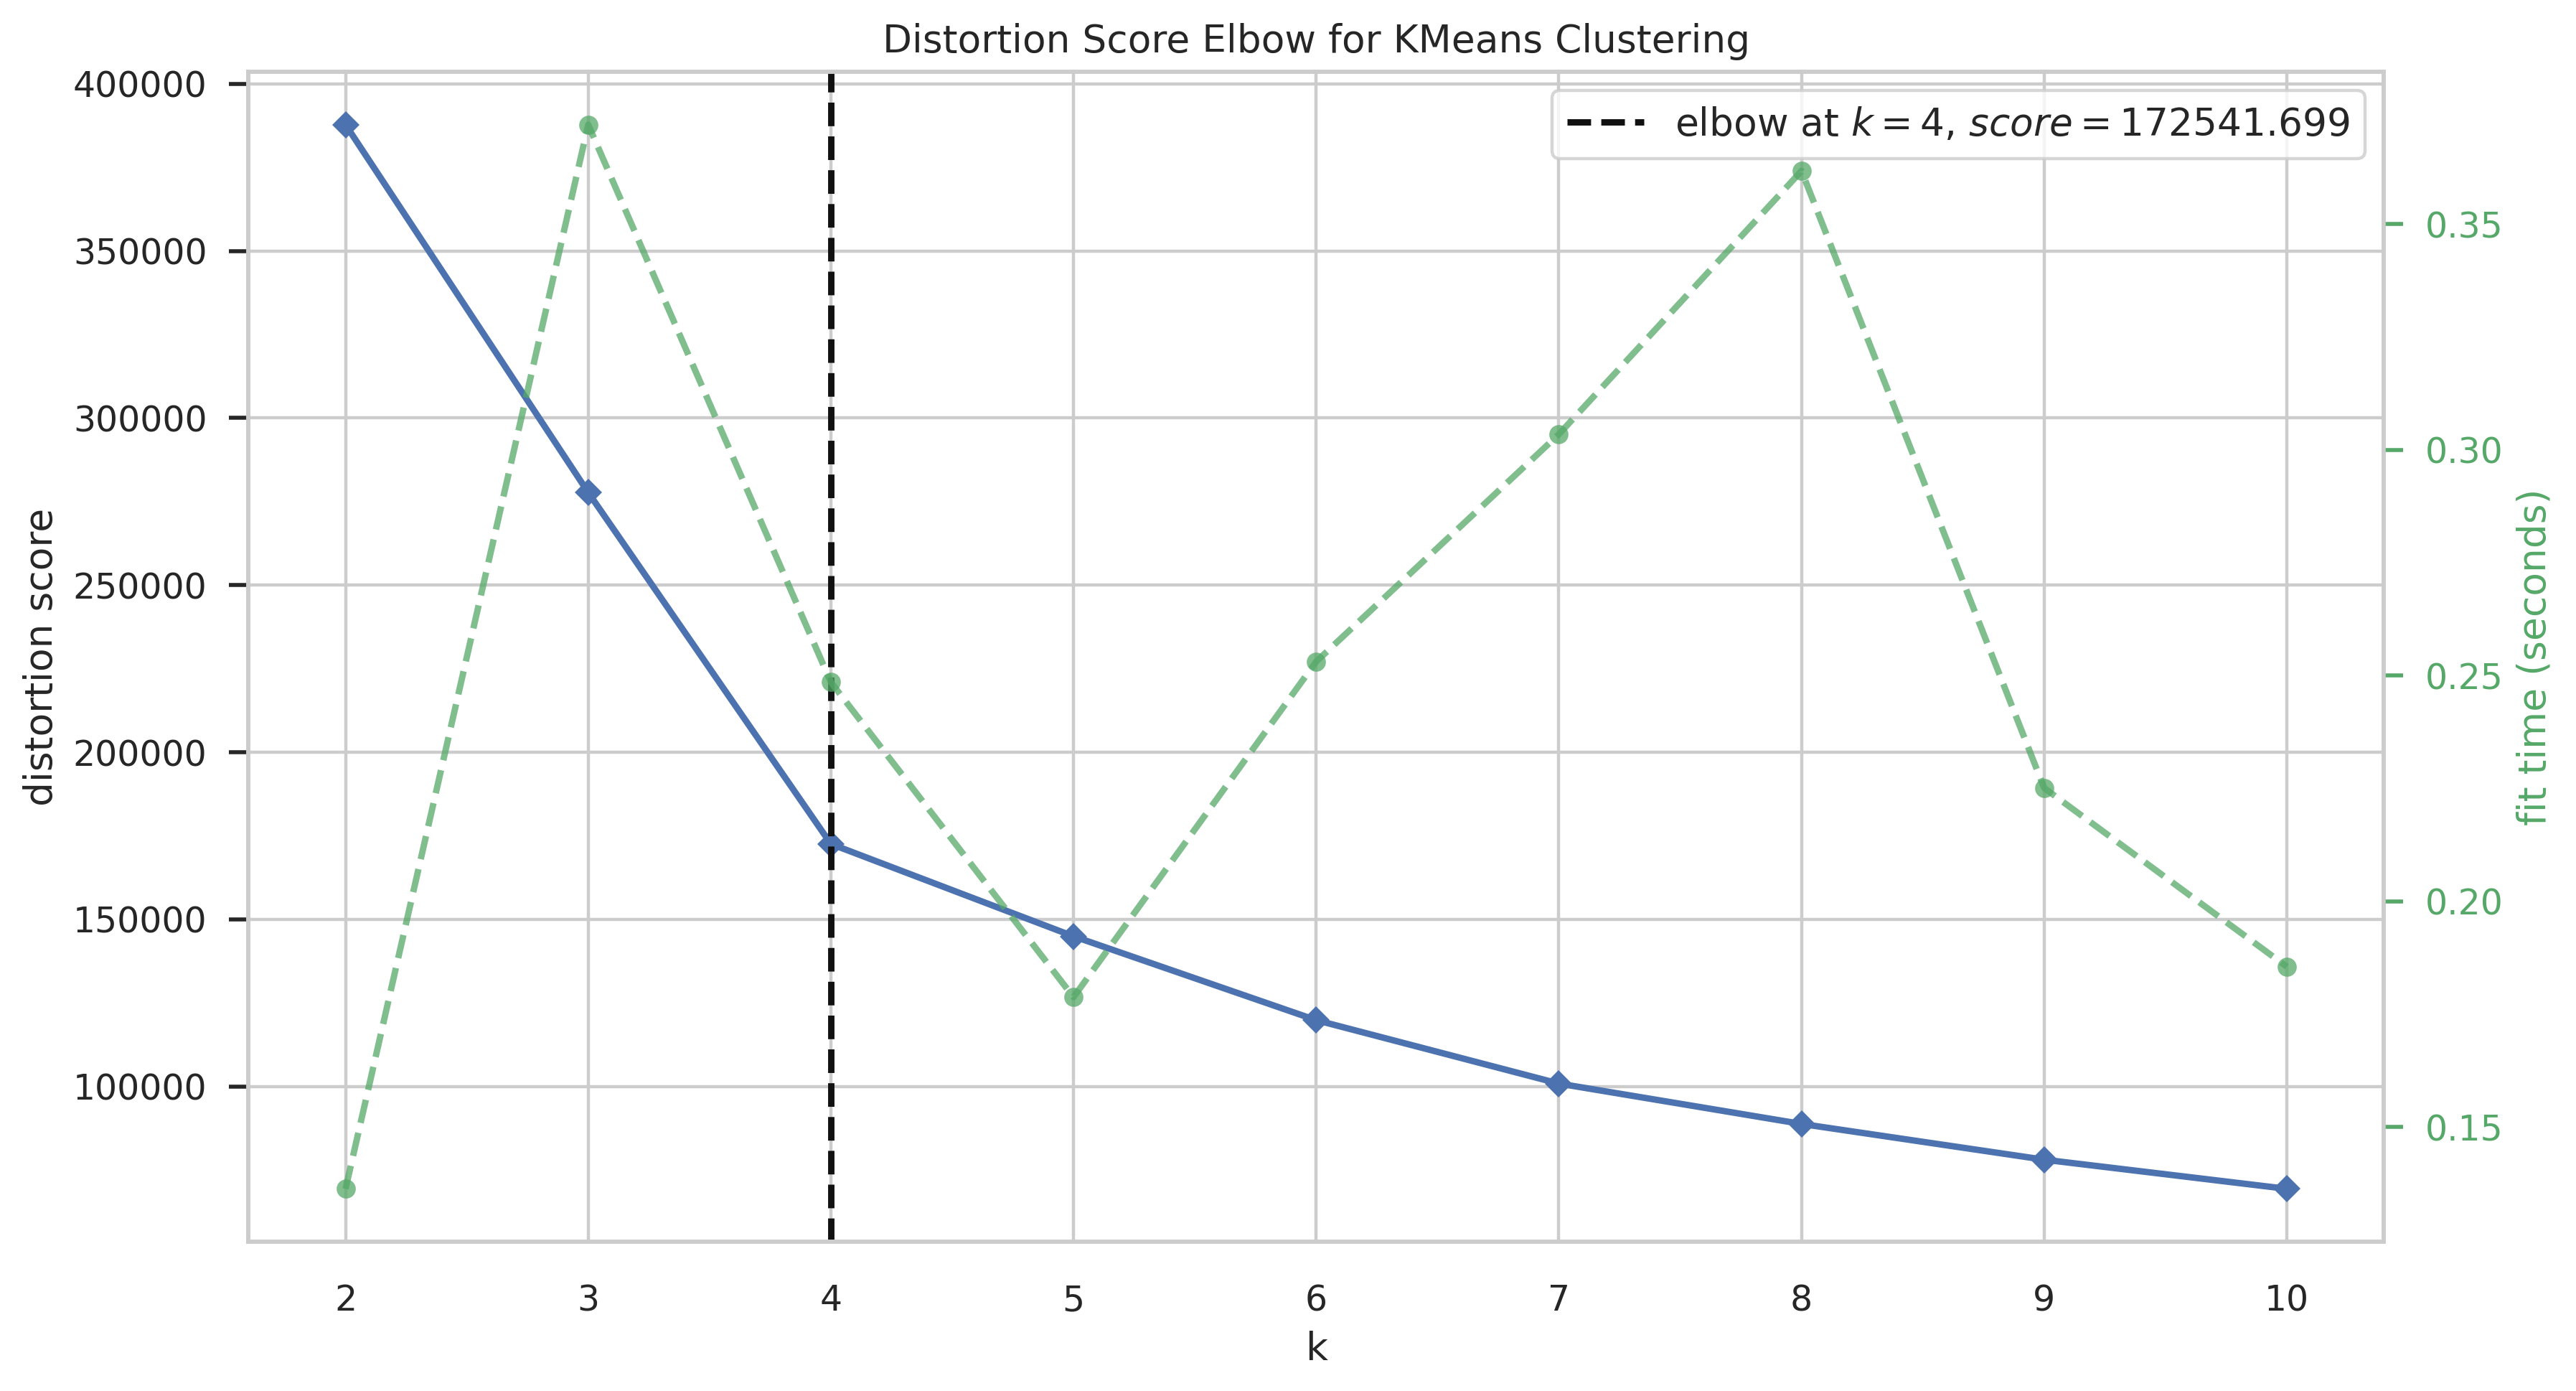

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [23]:
# distortion score identifying the elbow for the optimal k value
kelbow_visualizer(KMeans(random_state=10), X_tsne, k=(2, 11))

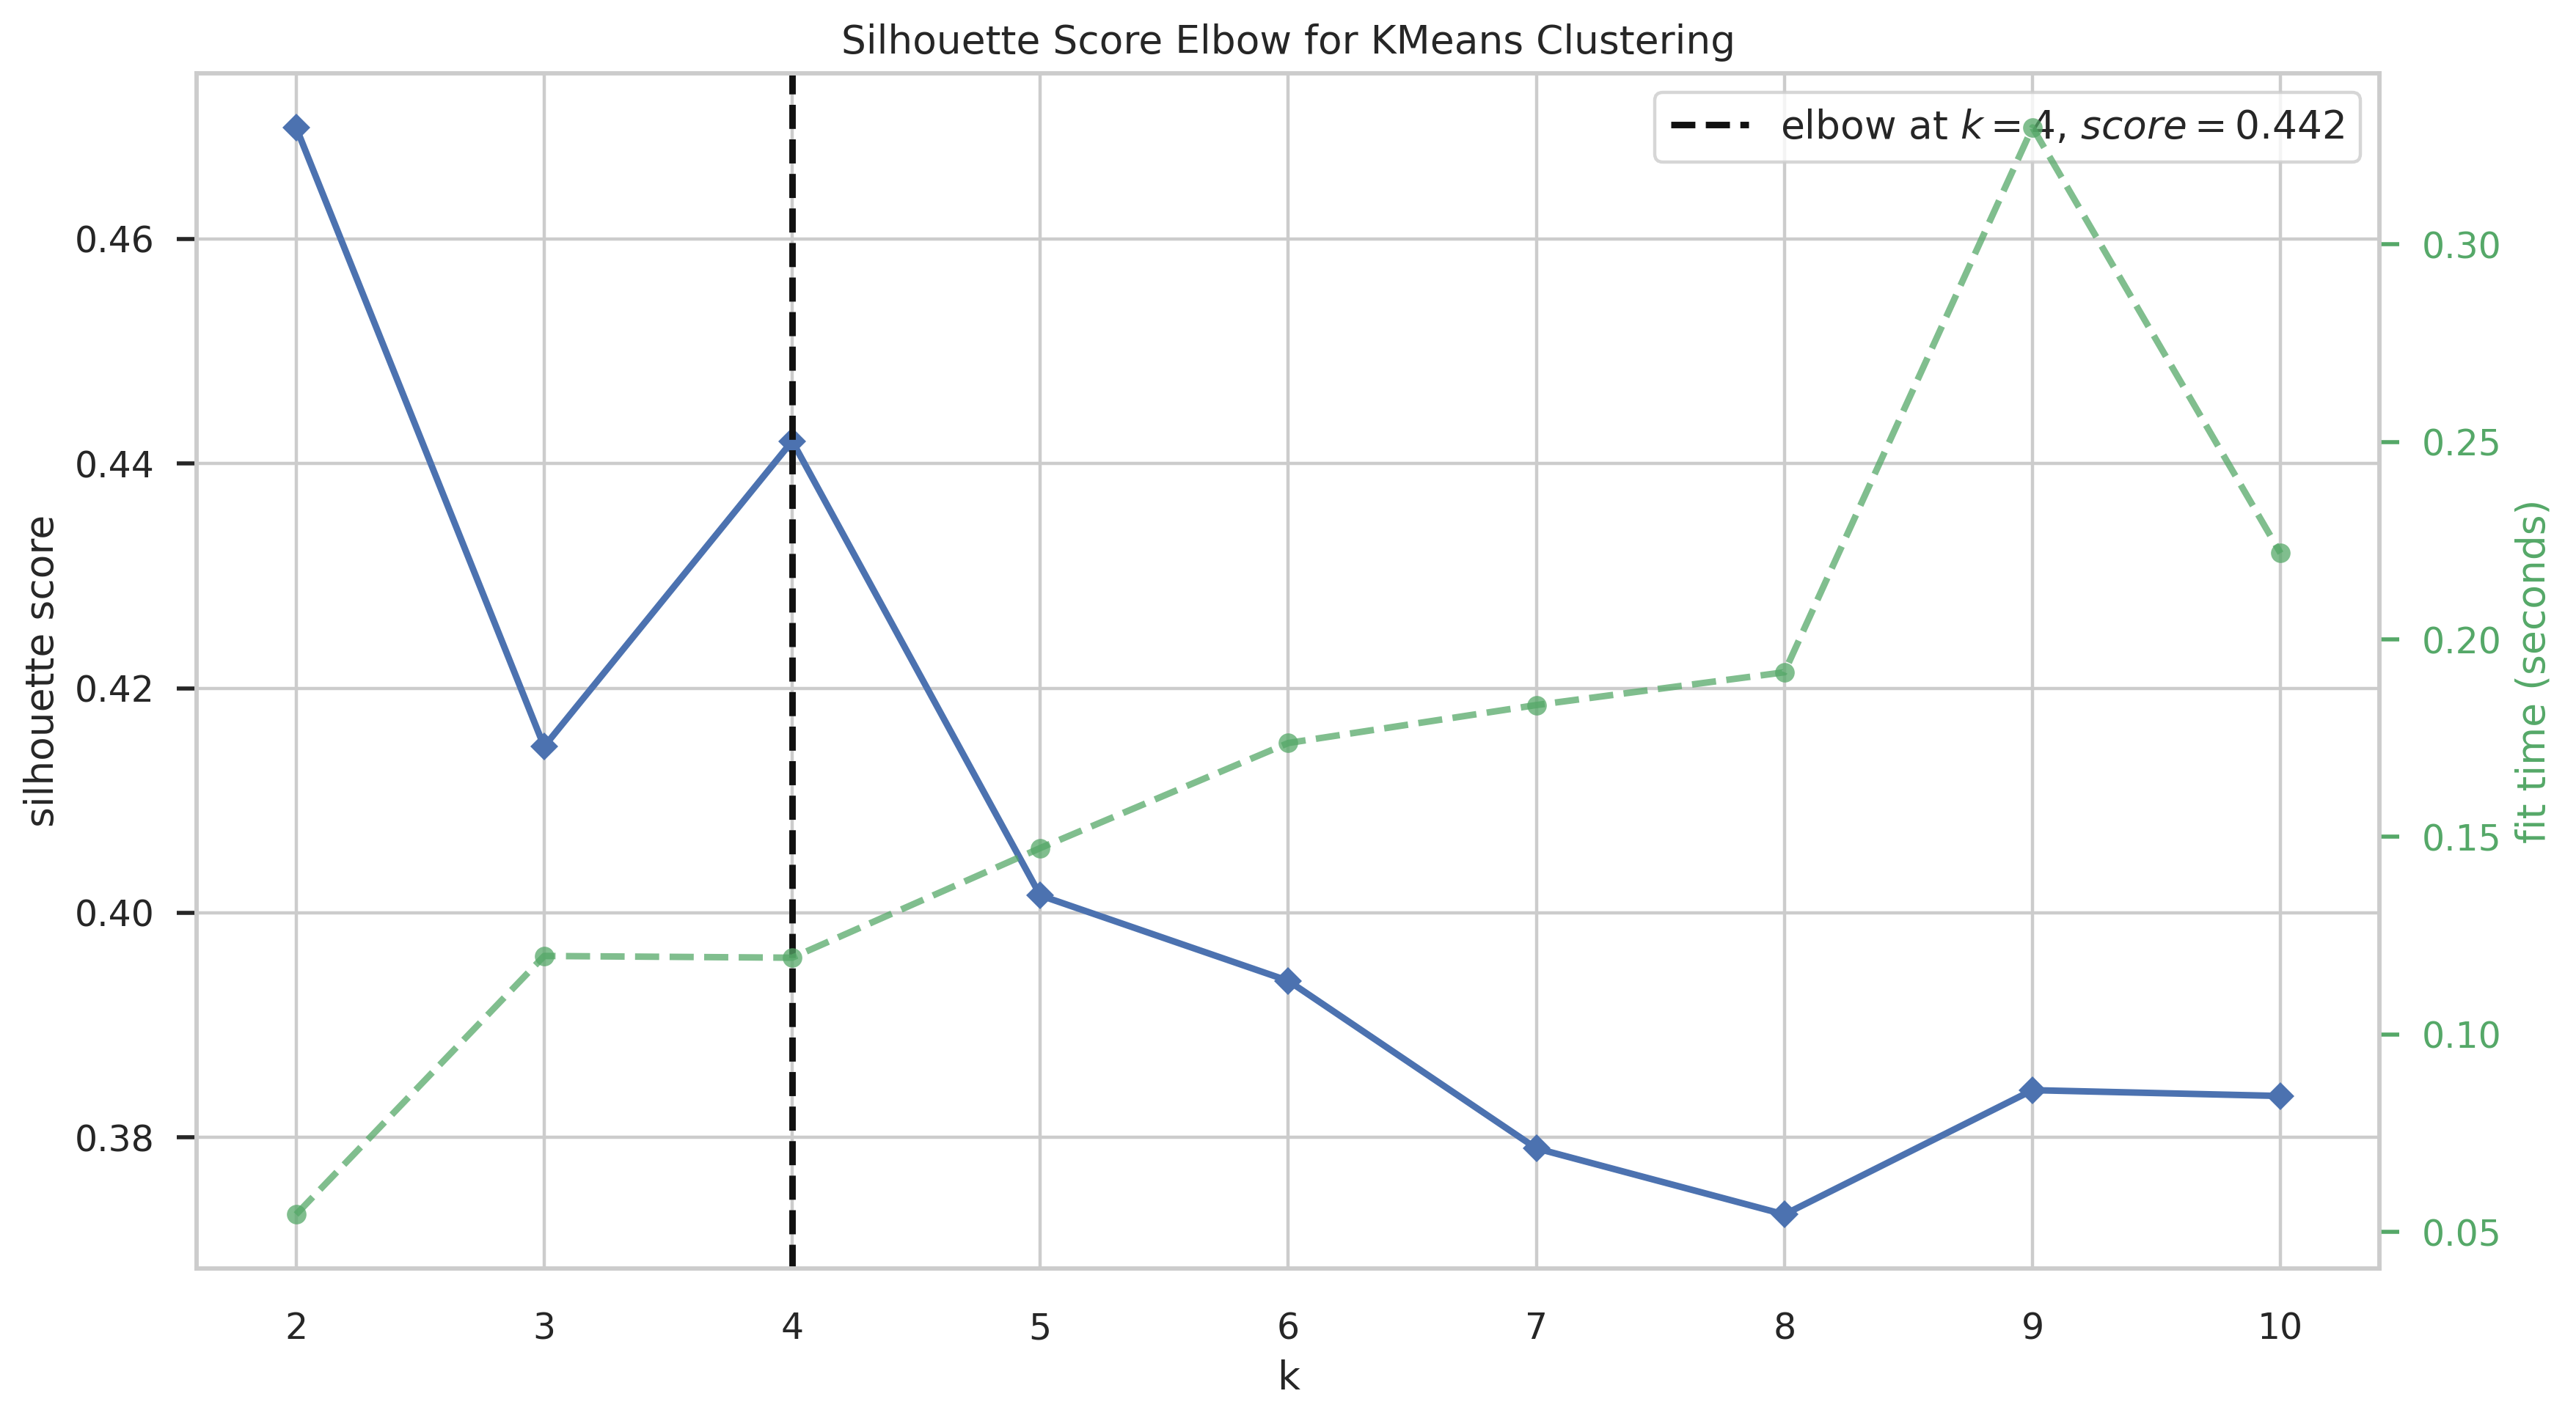

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=True)

In [24]:
# silhouette scores plotting the optimal k value
kelbow_visualizer(KMeans(random_state=10), X_tsne, k=(2, 11), metric="silhouette")

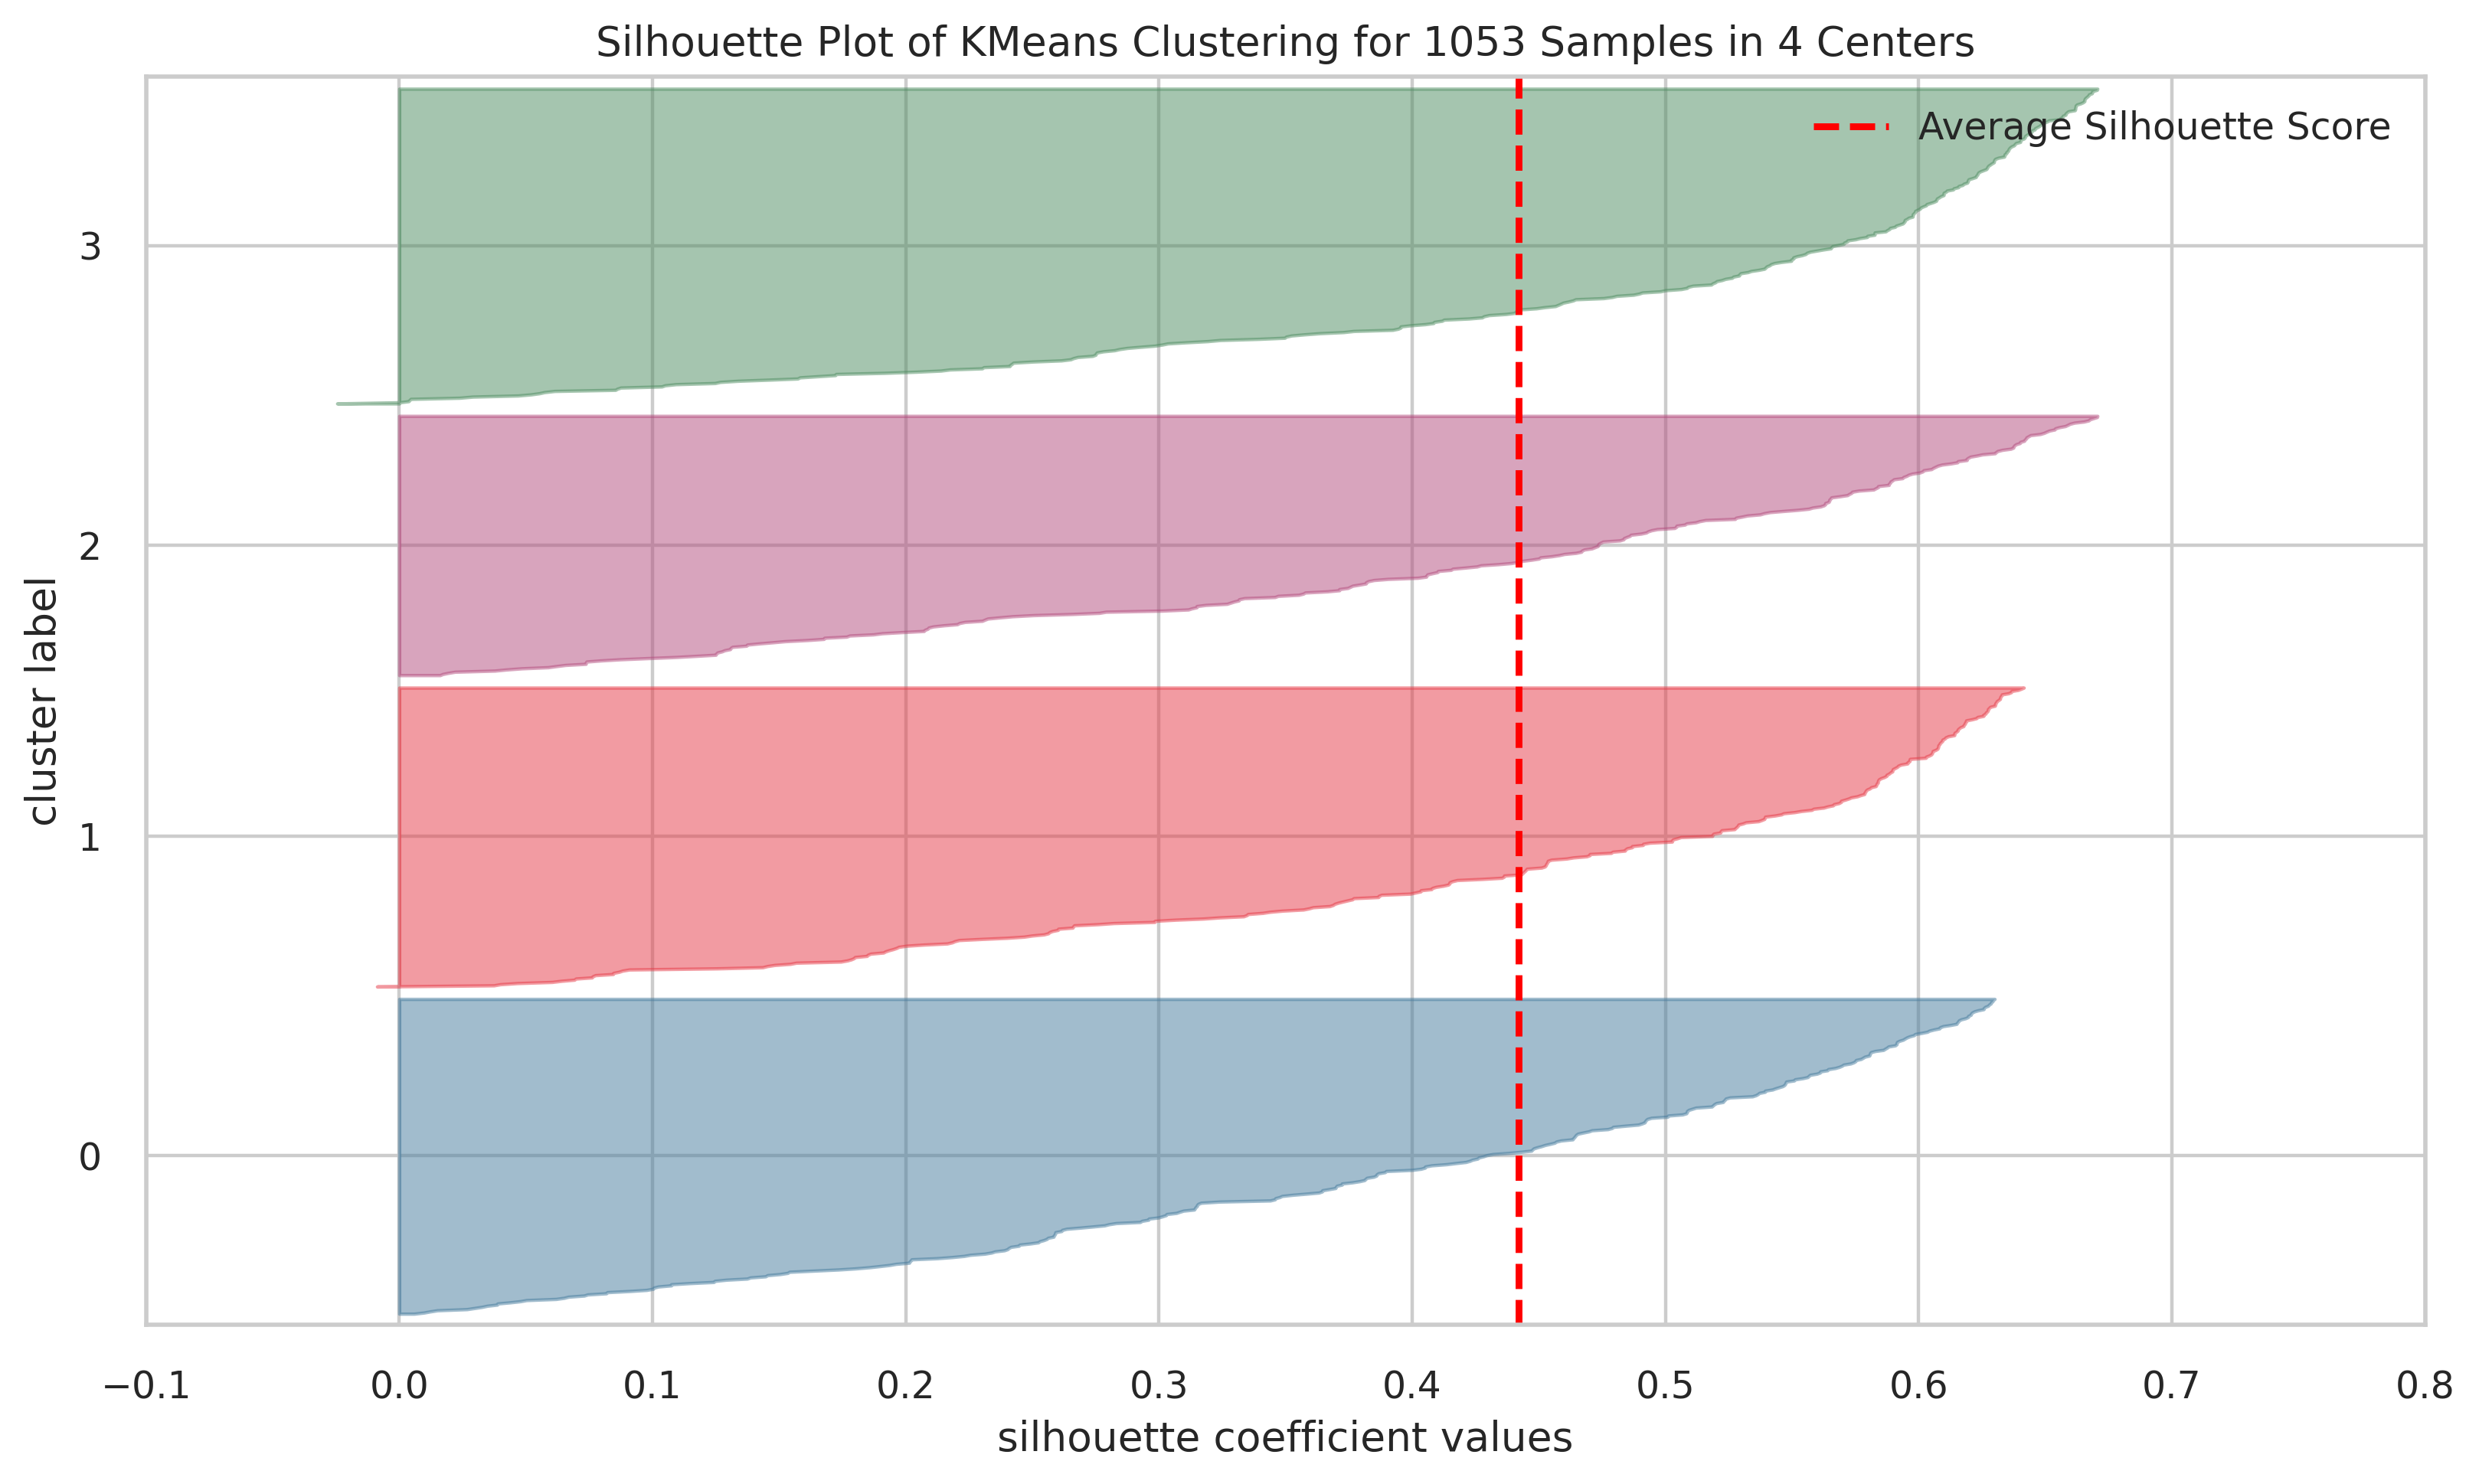

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1053 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors=['#457b9d', '#e63946', '#B34B7D', '#4D8C60'],
                     is_fitted='auto', model=None)

In [25]:
# silhouette plot when k=4
# the silhouette plots the score for observations in each cluster
# density is the thickness of each silhouette
silhouette_visualizer(
    KMeans(n_clusters=4, random_state=10), X_tsne, colors=custom_palette
)


### Cluster Analysis

In [26]:
# k-means using four clusters
km = KMeans(n_clusters=4, random_state=10)
# fit k-means algorithm on the data and save cluster labels
km.fit(X_tsne)
y = km.labels_

In [27]:
# create a df to store player names & season, cluster label, and distance from each cluster
players = pd.DataFrame(
    df.loc[(df["position"] == "FW") & (df["mins"] > 900)].dropna()[["player", "season"]]
)
labels = pd.DataFrame(y, columns=["cluster_label"], index=X.index)
cluster_locs = pd.DataFrame(km.fit_transform(X_tsne), index=X.index)
fw = pd.concat([players, labels, cluster_locs], axis=1, join="inner")

In [28]:
# expand pandas display to view all rows using pd.set_option()
# pd.set_option("display.max_rows", df.shape[0] + 1)

# sort df (by cluster label or player) for spot-checking results

# fw.sort_values("cluster_label")

In [29]:
# count the number of different clusters each player is assigned to
counts = pd.DataFrame(fw.groupby("player")["cluster_label"].nunique())
# identify the players that are only assigned to one cluster and drop them from the counts df
indexNames = counts[(counts["cluster_label"] == 1)].index
counts.drop(indexNames, inplace=True)
# count how many players are assigned to multiple clusters
len(counts)

# print counts to look at the players that are not labelled consistently
# print(counts)

119

### Visualizing Clusters

In [30]:
# create a df with observation's x, y locations in two-dimensional space
scaled_df = pd.DataFrame(X_tsne, columns=["tsne1", "tsne2"])
# add cluster labels to the df
scaled_df = pd.concat([scaled_df, pd.DataFrame({"clusters": y})], axis=1)

<AxesSubplot:title={'center':'Forward Clusters on tSNE Scaled Data'}, xlabel='tsne1', ylabel='tsne2'>

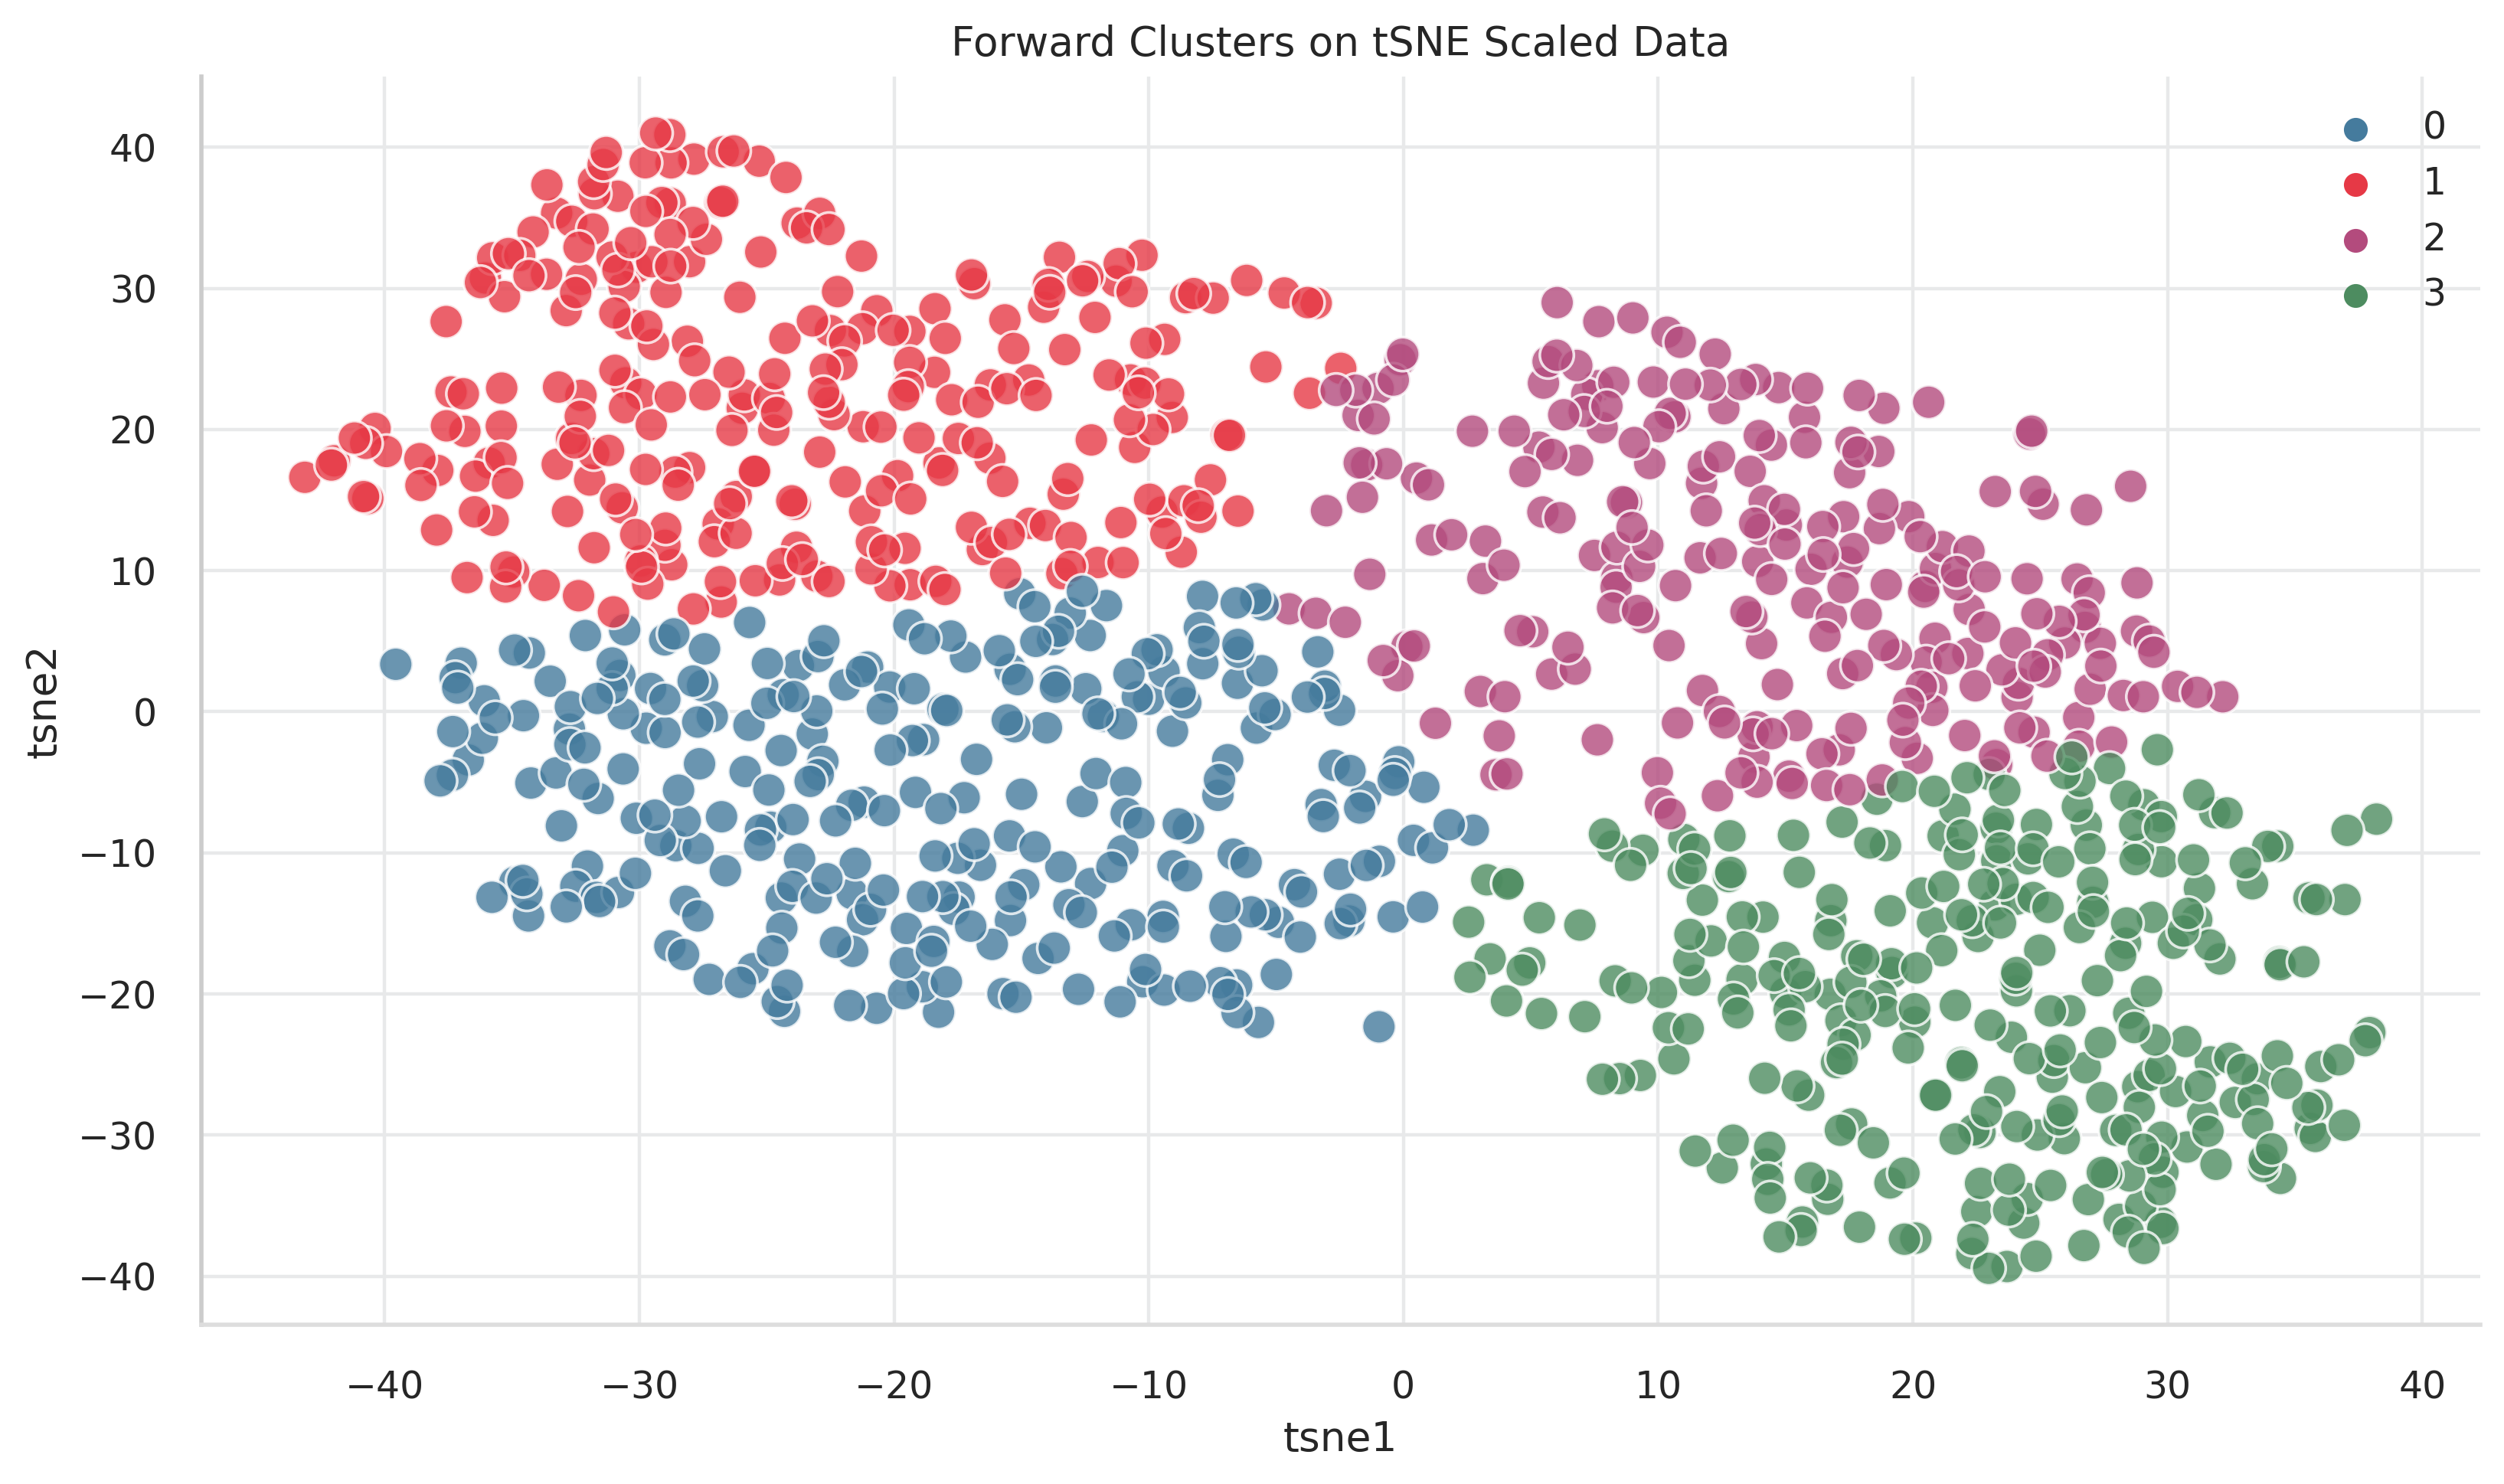

In [31]:
# plot tsne-scaled observations colored by cluster membership

cluster_plot(scaled_df, "Forward")

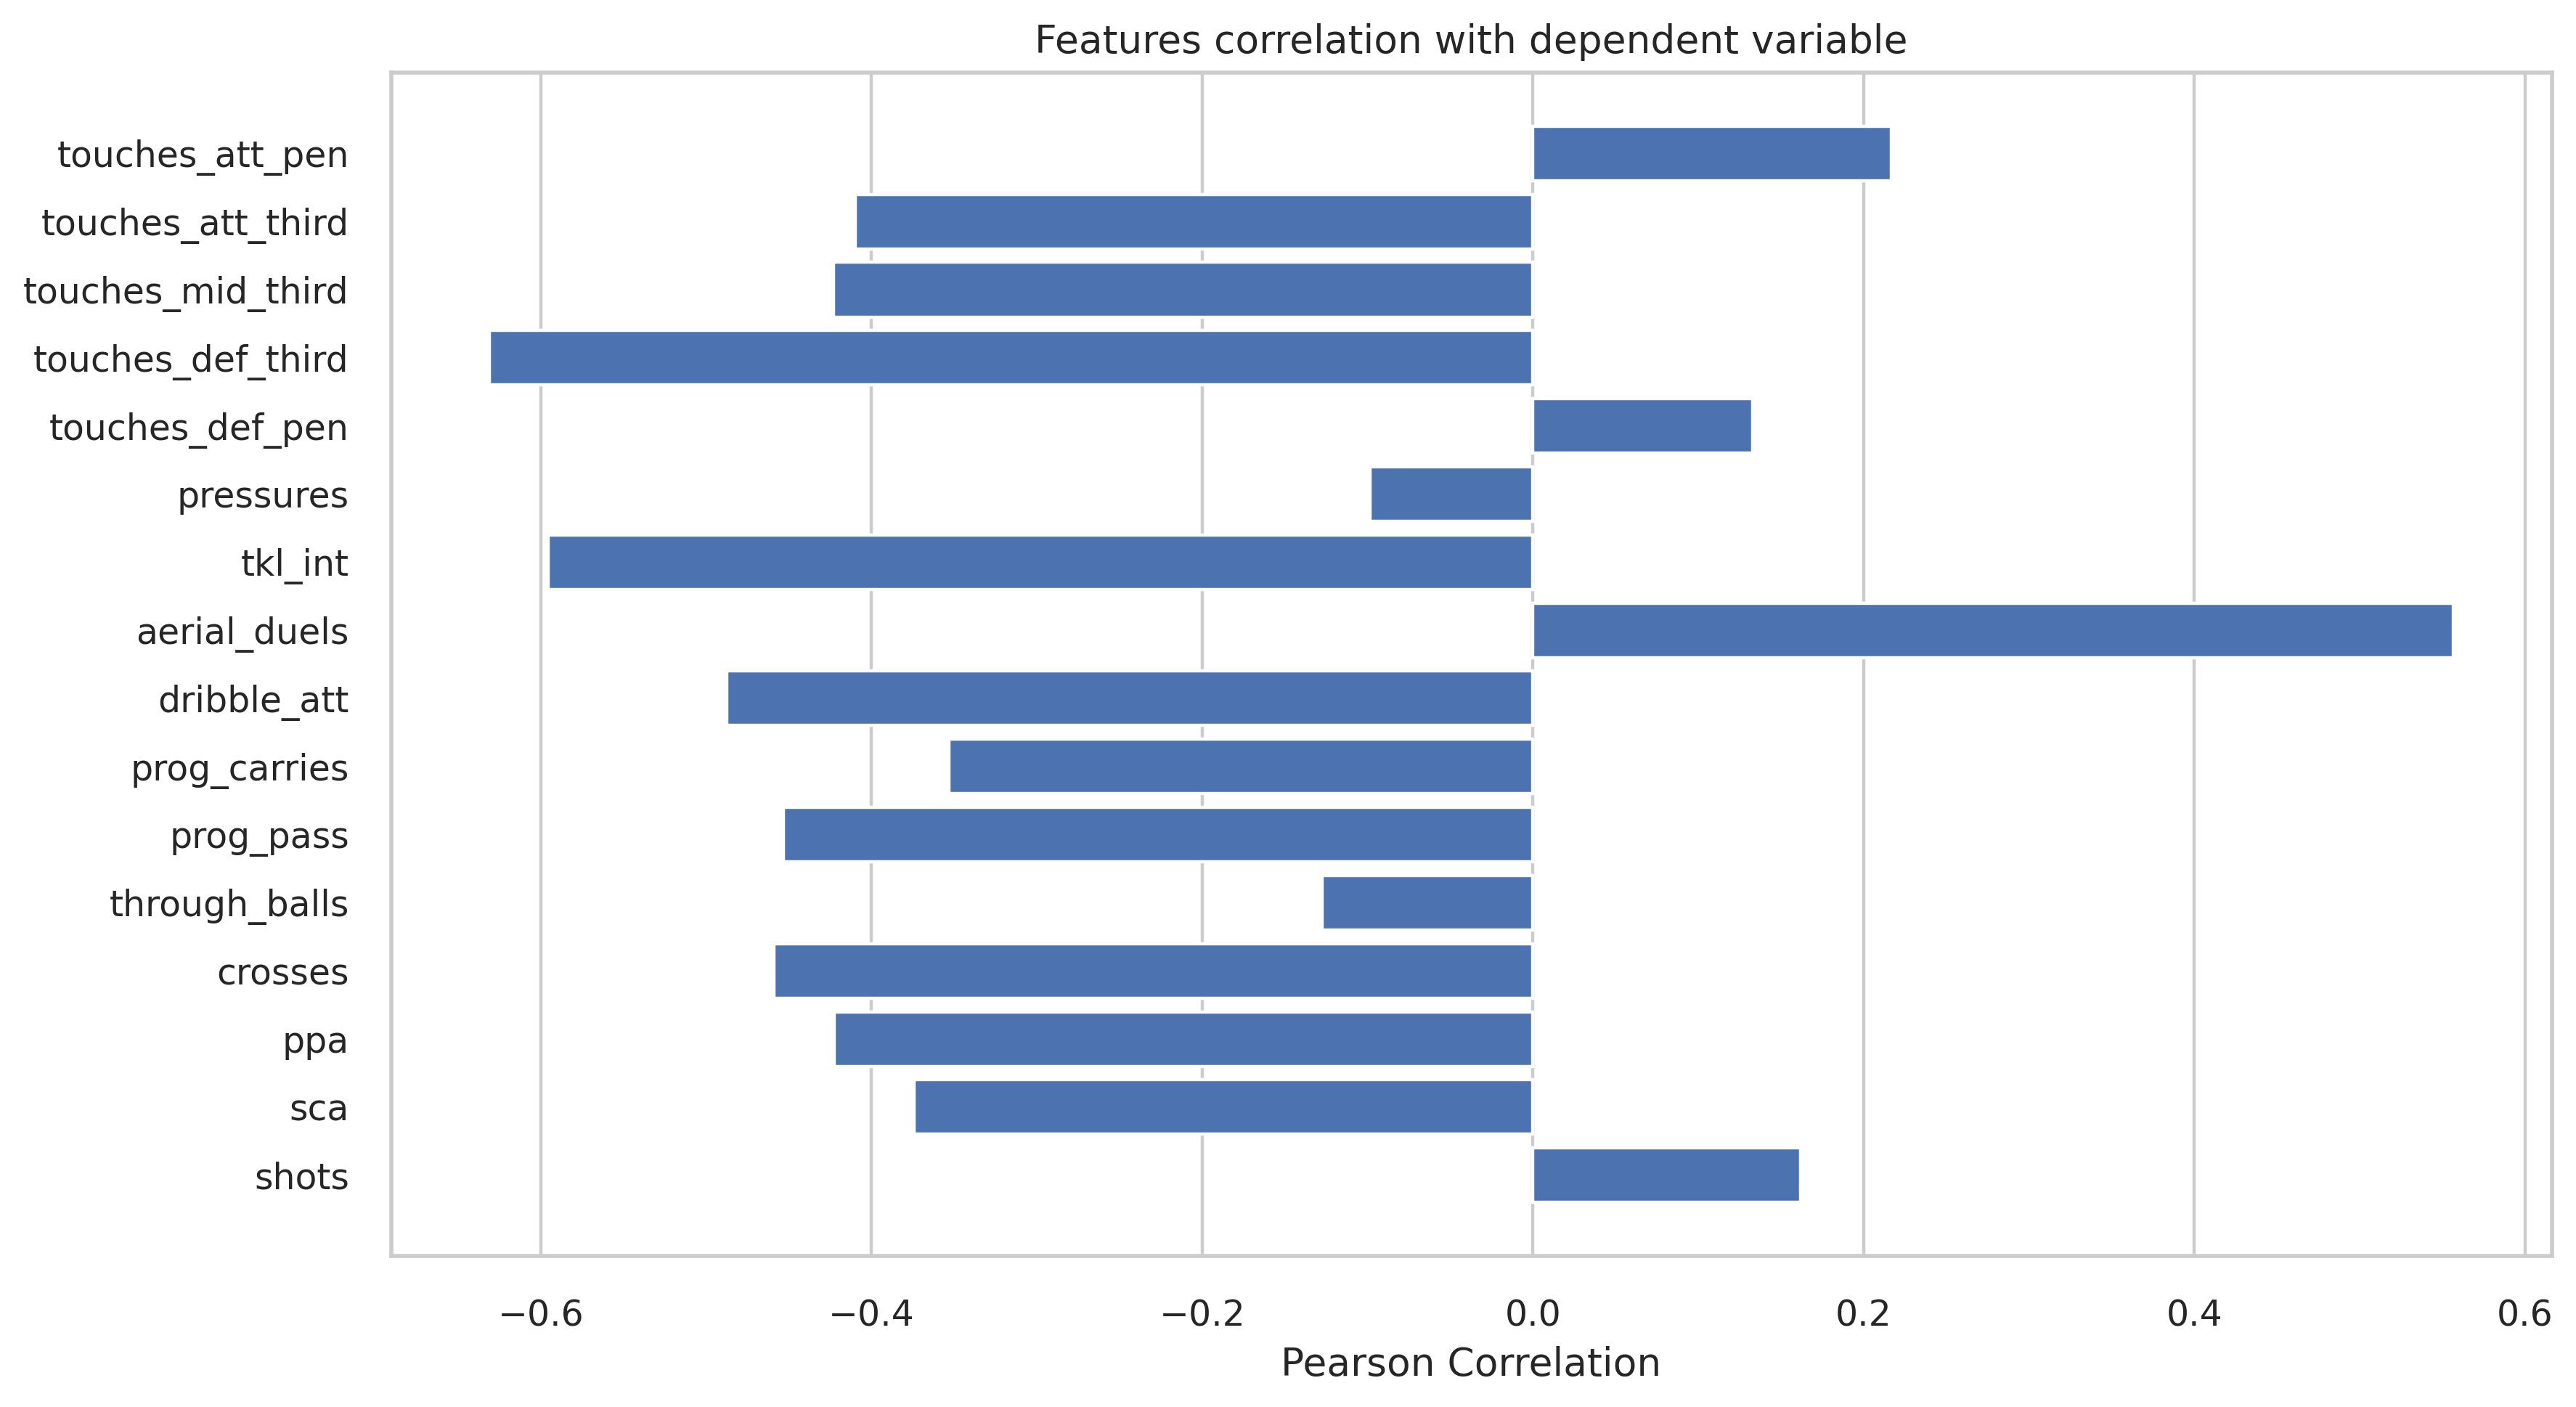

FeatureCorrelation(ax=<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>,
                   color=None, feature_index=None, feature_names=None,
                   labels=None, method='pearson', sort=False)

In [32]:
# plot the correlations between cluster labels and original features to see which features are driving most of the variance
# positive correlations driving higher cluster labels, negative correlations associated with lower values
feature_correlation(X, y)

### Pickling Model Outputs

In [33]:
pickle.dump(km, open("km_fwds.pickle", "wb"))
pickle.dump(fw, open("fw_results.pickle", "wb"))